# First 'working' Notebook Version

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
import scipy.stats as stats
from scipy.optimize import curve_fit
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import pi


In [2]:
np.random.seed(0)

In [3]:
def simpsons_rule_normal(lb, ub, n, sig, offset):
    h = (ub - lb) / n
    x = [lb + i*h for i in range(n+1)]
    pdfs = lambda x, mu, sig: 1/((2*pi)**0.5 * sig) * pyo.exp(-0.5 * ((x-mu)/sig)**2) 
    integrand = lambda x, sig: x * pdfs(x + offset, mu=0, sig=sig) # x * pdf(x+offset)
    y = [integrand(xi, sig) for xi in x]

    approximated_integral = h/3 * (y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2]))
    return approximated_integral


def simpsons_rule_2_logistic(lb, ub, n, w1, w2, w3, w4, w5, w6, offset):
    h = (ub - lb) / n
    x = [lb + i*h for i in range(n+1)]
    pdfs = lambda x, w1, w2, w3, w4, w5, w6: w1 * w2 * pyo.exp(-w2 * (x - w3)) / (1 + pyo.exp(-w2 * (x - w3)))**2 + w4 * w5 * pyo.exp(-w5 * (x - w6)) / (1 + pyo.exp(-w5 * (x - w6)))**2
    integrand = lambda x, w1, w2, w3, w4, w5, w6: x * pdfs(x + offset, w1, w2, w3, w4, w5, w6) 
    y = [integrand(xi, w1, w2, w3, w4, w5, w6) for xi in x]

    approximated_integral = h/3 * (y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2]))
    return approximated_integral


def simpsons_rule_uniform(lb, ub, n, lb_pdf, ub_pdf):
    step = (ub - lb) / n
    x = [lb + i*step for i in range(n+1)]
    integrand = lambda x: x * 1 / (ub_pdf - lb_pdf)  # x * pdf(x)
    y = [integrand(x_i) for x_i in x]

    res = y[0] + y[-1] + 4 * sum(y[1:-1:2]) + 2 * sum(y[2:-1:2])
    return step / 3 * res

def simpsons_rule_quadratic(lb, ub, n, offset):
    h = (ub - lb) / n
    x = [lb + i*h for i in range(n+1)]
    integrand = lambda x: x * (-(x+offset)**2 + (3/4)**(2/3)) # x * pdf(x+offset)
    y = [integrand(xi) for xi in x]

    approximated_integral = h/3 * (y[0] + y[-1] + 4*sum(y[1:-1:2]) + 2*sum(y[2:-1:2]))
    return approximated_integral

In [4]:
# Load/Use more realistic data for a day
# Data from Dorina - building No. 109
path = 'C:\\Users\\fh6281\\Desktop\\work\\Daten\\Dorina\\probabilistisch - 08_04_2024\\power.csv'
power_fc = pd.read_csv(path, parse_dates=["time"], index_col=('time', 'probability'))

prosumption_realistic = []
std_abweichung_realistic = []
for h in range(0, 24):
    power_quantiles = power_fc.iloc[:99, h].values
    mean, std = stats.norm.fit(power_quantiles)
    prosumption_realistic.append(mean)
    std_abweichung_realistic.append(std)
    #print(f"Hour {h+12}: mean={mean}, std={std}")   
    print(f"{mean}")   


-0.3139020577470461
-0.25899265914485603
-0.1360766560067279
0.11122220009725306
0.36931849884332113
0.6949445586940557
0.8557608490114412
0.8302261914599951
0.8589618979323692
0.907985972645354
1.1135154892524157
0.6768776846257687
0.47794256270082314
0.4346184374783187
0.4335427868245828
0.43459160889335213
0.44785789595162395
0.46722400905778905
0.9037651394665092
0.4733544370204661
0.13915947506825127
-0.11720737789119717
-0.29661608913015913
-0.358949458562816


In [5]:
from scipy.integrate import quad

# Preprare usage of sum of 2 logistic functions for the prosumption
def sum_2_logistic_cdf(x, w1, w2, w3, w4, w5, w6):
    return w1 / (1 + np.exp(-w2 * (x - w3))) + w4 / (1 + np.exp(-w5 * (x - w6)))

def sum_2_logistic_pdf(x, w1, w2, w3, w4, w5, w6):
    return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2

def sum_of_logistics_pdf_normalized(x, w1, w2, w3, w4, w5, w6):
    logistic1 = w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2  
    logistic2 = w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2  
    
    # Numerical integration over the range of x to compute the normalization factor
    integral, _ = quad(lambda t: w1 * w2 * np.exp(-w2 * (t - w3)) / (1 + np.exp(-w2 * (t - w3)))**2 + w4 * w5 * np.exp(-w5 * (t - w6)) / (1 + np.exp(-w5 * (t - w6)))**2, -10, 10 )
    
    # Return the sum normalized by the integral
    return (logistic1 + logistic2) / integral


# Problem: Fitting the logistic functions to the cdf data from Dorina results in pdfs that do not integrate to one.
# Solution: Create artificial data that is based on dorinas data but the pdfs are fitted (instead of the cdfs)


# Step 1: Get weights for the logistic functions via a fitting process.
x_quantiles = np.linspace(0.01, 0.99, 99)
weights_unnormalized = []
for h in range(0, 24):
    power_quantiles = power_fc.iloc[:99, h].values

    # Get inital weights (unnormalized) for the sum of 2 logistic functions
    if h == 0: 
        weights = [0.99967495, 5.117566, 0.72800567, 0.0, 0.0, 0.0]
    elif h == 1: 
        weights = [0.99967495, 5.117566, 0.72800567, 0.0, 0.0, 0.0]
    elif h == 5: 
        weights = [0.99967495, 5.117566, 0.72800567, 0.0, 0.0, 0.0] # use single logistic function here instead -> weird outlier outside of the range
    elif h == 7: 
        weights = [0.97455708, 7.25075964, 0.81333605, 0.0, 0.0, 0.0]
    elif h == 8:
        weights = [0.98482503, 7.30661912, 0.84453286, 0.0, 0.0, 0.0] # use single logistic function here instead -> double does not converge
    elif h == 10:
        weights = [1.00334229, 4.21623847, 1.1167537, 0.0, 0.0, 0.0]
    elif h == 11:
        weights = [1.00334229, 4.21623847, 1.1167537, 0.0, 0.0, 0.0]
    elif h == 12:
        weights = [1.00334229, 4.21623847, 1.1167537, 0.0, 0.0, 0.0]
    elif h == 13:
        weights = [0.99405916, 19.66994906, 0.43363253, 0.0, 0.0, 0.0]
    elif h == 14:
        weights = [0.99405916, 19.66994906, 0.43363253, 0.0, 0.0, 0.0]
    elif h == 15:
        weights = [1.00165363, 23.18201043, 0.44108622, 0.0, 0.0, 0.0]
    elif h == 16:
        weights = [1.00165363, 23.18201043, 0.44108622, 0.0, 0.0, 0.0]
    elif h == 17:
        weights = [1.00165363, 23.18201043, 0.44108622, 0.0, 0.0, 0.0]
    elif h == 19:
        weights = [0.94455275, 8.91549959, 0.44368902, 0.0, 0.0, 0.0]
    elif h == 23:
        weights = [0.94455275, 8.91549959, 0.44368902, 0.0, 0.0, 0.0]
    else:
        weights, _ = curve_fit(sum_2_logistic_cdf, power_quantiles, x_quantiles, maxfev=50000)
    weights_unnormalized.append(weights)

    
# Step 2: Use unnormalized weights and add noise to create pdf data that can be used for fitting
x_data = np.linspace(-10, 10, 100)
weights_normalized = []
for h in range(0, 24):
    y_data = sum_of_logistics_pdf_normalized(x_data, *weights_unnormalized[h]) #+ 0.001 * np.random.normal(size=x_data.size)  # Add noise to the data

    # Step 3: Fit to pdf data and ensure normalization
    weights_normalized_h, _ = curve_fit(sum_of_logistics_pdf_normalized, x_data, y_data, maxfev=50000)
    weights_normalized.append(weights_normalized_h)


# Check if the fitted pdfs integrate to one
for h in range(0, 24):
    integral, _ = quad(lambda x: sum_of_logistics_pdf_normalized(x, *weights_normalized[h]), -10, 10)
    print(f"Hour {h}: Total Probability={integral}")



C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:5: RuntimeWarning: overflow encountered in exp
  return w1 / (1 + np.exp(-w2 * (x - w3))) + w4 / (1 + np.exp(-w5 * (x - w6)))
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:18: RuntimeWarning: invalid value encountered in divide
  return (logistic1 + logistic2) / integral
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:11: RuntimeWarning: overflow encountered in exp
  logistic1 = w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:11: RuntimeWarning: invalid value encountered in divide
  logistic1 = w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:12: RuntimeWarning: overflow encountered in exp
  logistic2 = w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\369

Hour 0: Total Probability=0.9999999999999999
Hour 1: Total Probability=0.9999999999999999
Hour 2: Total Probability=1.0
Hour 3: Total Probability=0.9999999999999998
Hour 4: Total Probability=1.0
Hour 5: Total Probability=0.9999999999999999
Hour 6: Total Probability=1.0000000000000002
Hour 7: Total Probability=1.0
Hour 8: Total Probability=0.9999999999999999
Hour 9: Total Probability=1.0000000000000002
Hour 10: Total Probability=1.0
Hour 11: Total Probability=1.0
Hour 12: Total Probability=1.0
Hour 13: Total Probability=1.0
Hour 14: Total Probability=1.0
Hour 15: Total Probability=1.0
Hour 16: Total Probability=1.0
Hour 17: Total Probability=1.0
Hour 18: Total Probability=1.0
Hour 19: Total Probability=0.9999999999999999
Hour 20: Total Probability=1.0
Hour 21: Total Probability=1.0000000000000002
Hour 22: Total Probability=1.0
Hour 23: Total Probability=0.9999999999999999


In [6]:
y_data

array([3.25596869e-40, 1.97193593e-39, 1.19427786e-38, 7.23299164e-38,
       4.38056919e-37, 2.65303589e-36, 1.60677737e-35, 9.73124231e-35,
       5.89360286e-34, 3.56938544e-33, 2.16175279e-32, 1.30923802e-31,
       7.92923320e-31, 4.80223901e-30, 2.90841484e-29, 1.76144438e-28,
       1.06679633e-27, 6.46091601e-27, 3.91297142e-26, 2.36984126e-25,
       1.43526415e-24, 8.69249438e-24, 5.26449842e-23, 3.18837636e-22,
       1.93099950e-21, 1.16948523e-20, 7.08283824e-20, 4.28963069e-19,
       2.59796015e-18, 1.57342145e-17, 9.52922643e-17, 5.77125452e-16,
       3.49528673e-15, 2.11687585e-14, 1.28205888e-13, 7.76462617e-13,
       4.70254686e-12, 2.84803756e-11, 1.72487765e-10, 1.04465016e-09,
       6.32679052e-09, 3.83174000e-08, 2.32064439e-07, 1.40546832e-06,
       8.51202616e-06, 5.15515037e-05, 3.12196855e-04, 1.89011104e-03,
       1.14227088e-02, 6.82913431e-02, 3.83107018e-01, 1.53985491e+00,
       2.07008739e+00, 7.09717542e-01, 1.36312669e-01, 2.31025355e-02,
      

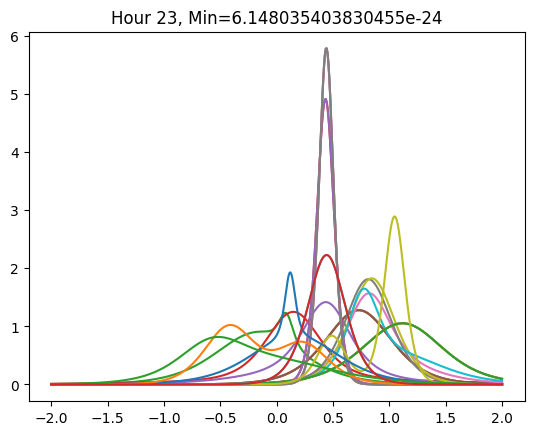

In [7]:
# Plot the fitted, normalized and UNSIHFTED pdfs
x_data = np.linspace(-2, 2, 500)
y_min_old = 1.0
for h in range(0, 24):
    y_data = sum_of_logistics_pdf_normalized(x_data, *weights_normalized[h])
    y_min_new = np.min(y_data)
    if y_min_new < y_min_old:
        y_min_old = y_min_new
    plt.plot(x_data, y_data)
    plt.title(f"Hour {h}, Min={y_min_old}")
plt.show()

In [8]:
# Shift the pdfs to have an expected value of 0
weights_normalized_shifted = []
pl_hat_realistic = []
for h in range(0, 24):
    weights_normalized_h = weights_normalized[h].copy()
    expected_val = quad(lambda x: x * sum_of_logistics_pdf_normalized(x, *weights_normalized_h), -10, 10)[0]
    pl_hat_realistic.append(expected_val)

    # Shift the corresponding weights to have an expected value of 0
    weights_normalized_h[2] -= expected_val
    weights_normalized_h[5] -= expected_val
    weights_normalized_shifted.append(weights_normalized_h)

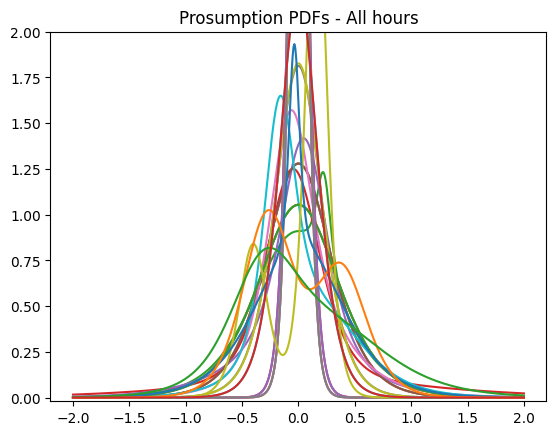

In [9]:
# Plot the fitted, normalized and SHIFTED pdfs
x_data = np.linspace(-2, 2, 500)
for h in range(0, 24):
    y_data = sum_of_logistics_pdf_normalized(x_data, *weights_normalized_shifted[h])
    plt.plot(x_data, y_data)
    plt.ylim(-0.02, 2)
    plt.title(f"Prosumption PDFs - All hours")
plt.show()

In [10]:
# check if the shifted pdfs have an expected value of 0
for h in range(0, 24):
    expected_val = quad(lambda x: x * sum_of_logistics_pdf_normalized(x, *weights_normalized_shifted[h]), -10, 10)[0]
    #expected_val = quad(lambda x: x * sum_2_logistic_pdf(x, *weights_normalized_shifted[h]), -10, 10)[0]
    integral, _ = quad(lambda x: sum_of_logistics_pdf_normalized(x, *weights_normalized_shifted[h]), -10, 10)
    #integral, _ = quad(lambda x: sum_2_logistic_pdf(x, *weights_normalized_shifted[h]), -10, 10)
    print(f"Hour {h}: Expected Value={expected_val} Total Probability={integral}")

Hour 0: Expected Value=-1.6138125993453456e-14 Total Probability=1.0
Hour 1: Expected Value=-1.6138125993453456e-14 Total Probability=1.0
Hour 2: Expected Value=5.009881398621019e-15 Total Probability=1.0
Hour 3: Expected Value=8.116381541162232e-07 Total Probability=1.0000000000000002
Hour 4: Expected Value=8.64489035912186e-12 Total Probability=1.0


KeyboardInterrupt: 

C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:8: RuntimeWarning: overflow encountered in exp
  return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:8: RuntimeWarning: invalid value encountered in divide
  return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:8: RuntimeWarning: overflow encountered in multiply
  return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\3698303378.py:8: RuntimeWarning: overflow encountered in square
  return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * 

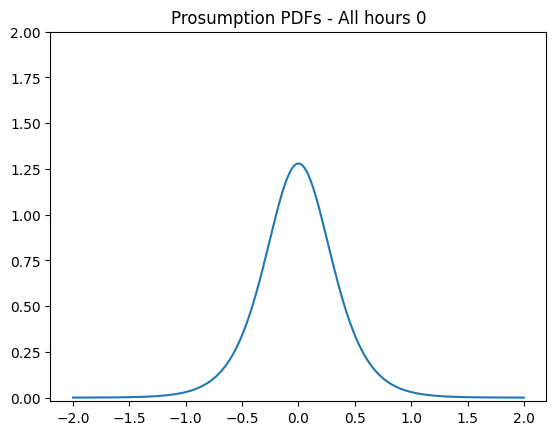

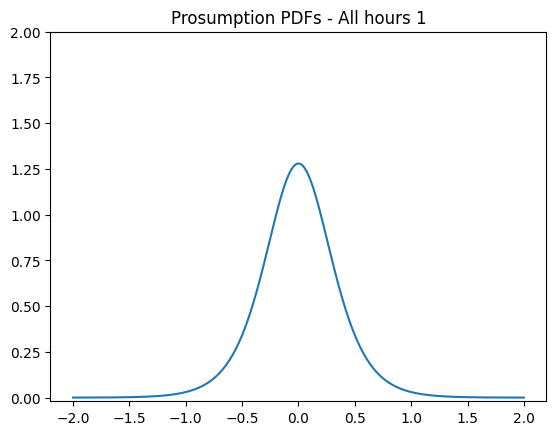

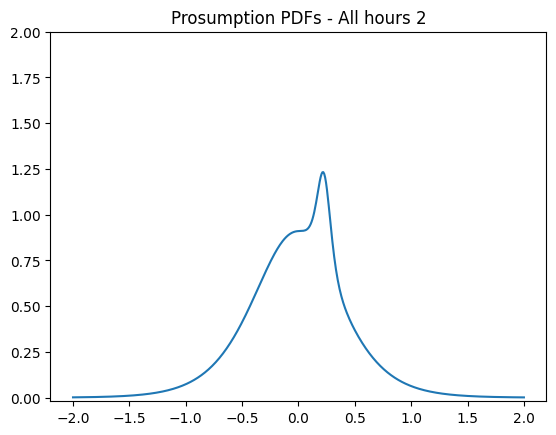

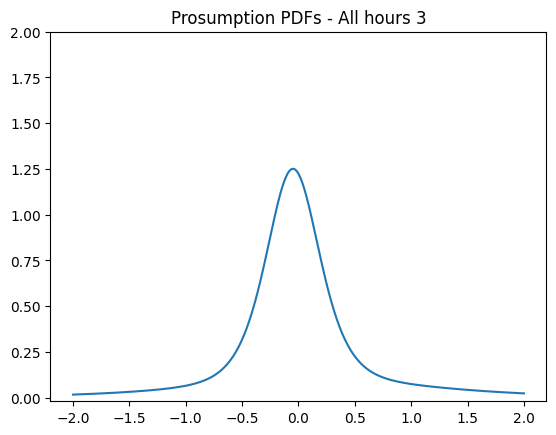

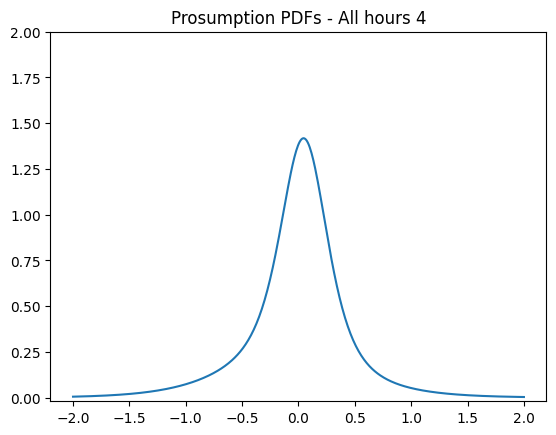

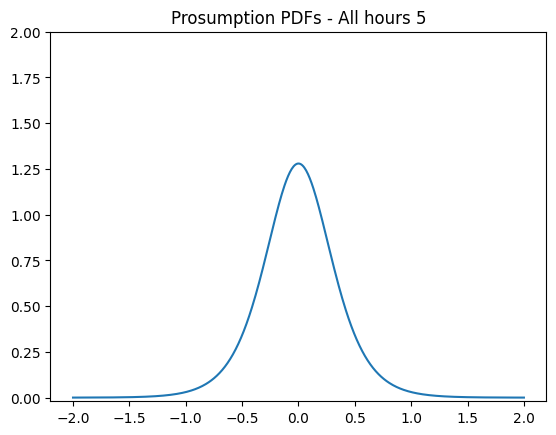

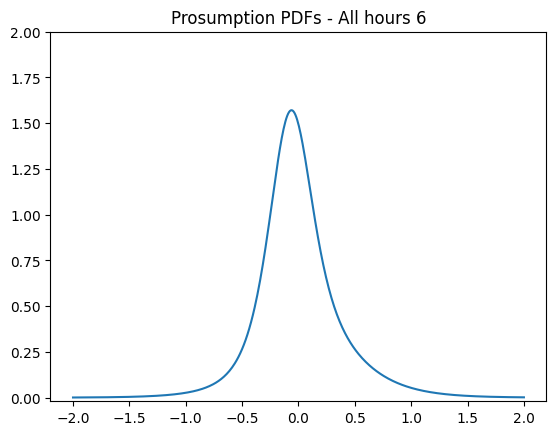

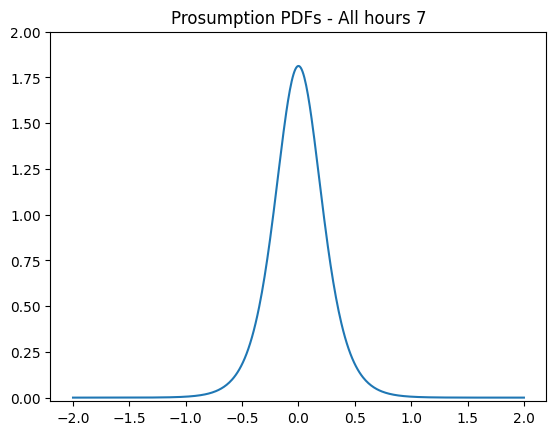

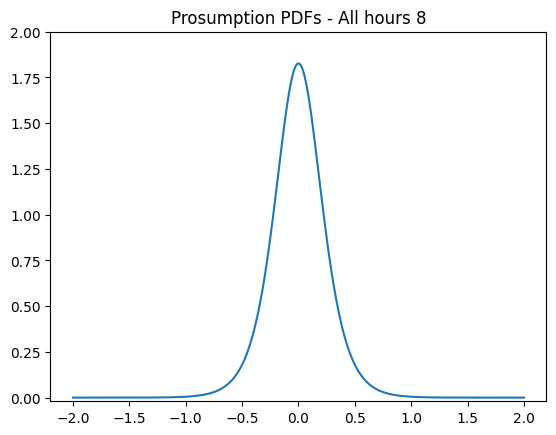

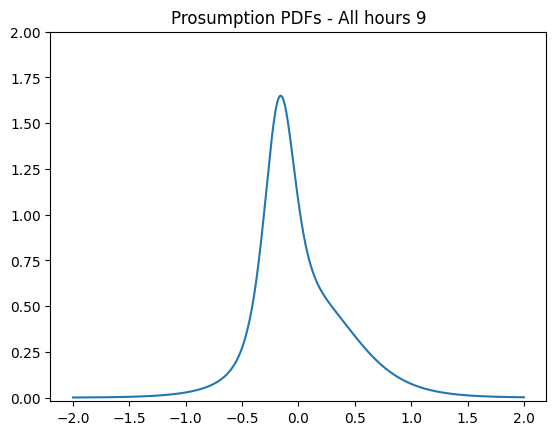

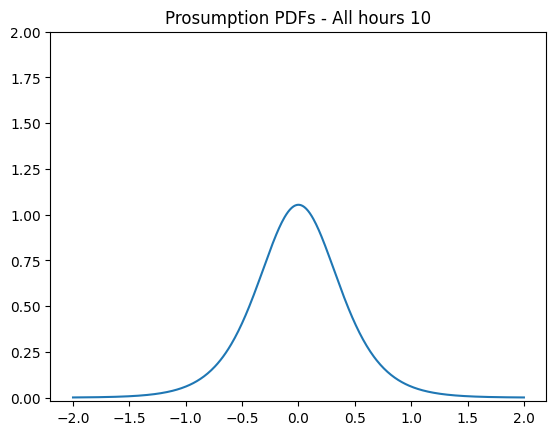

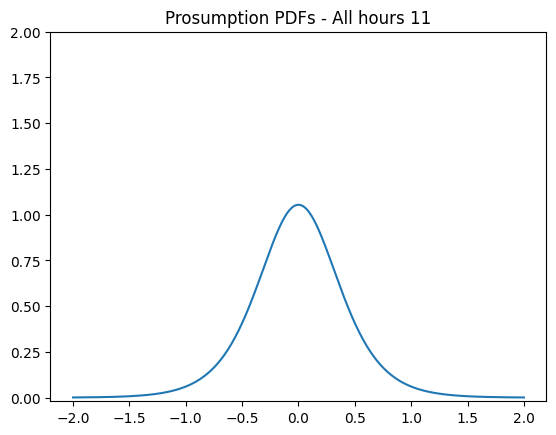

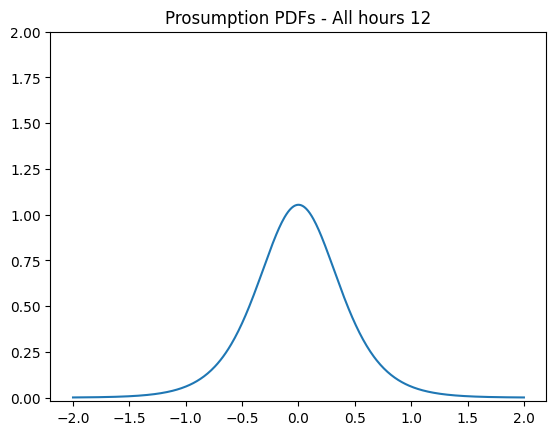

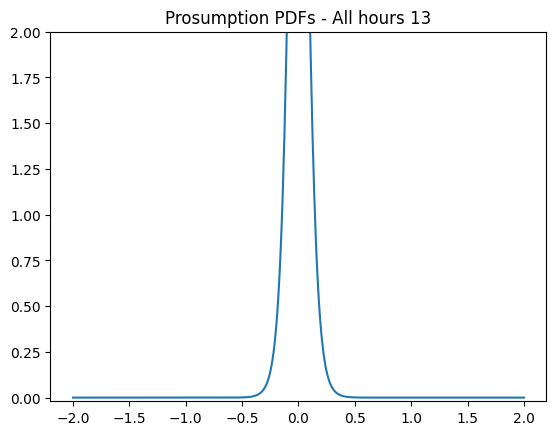

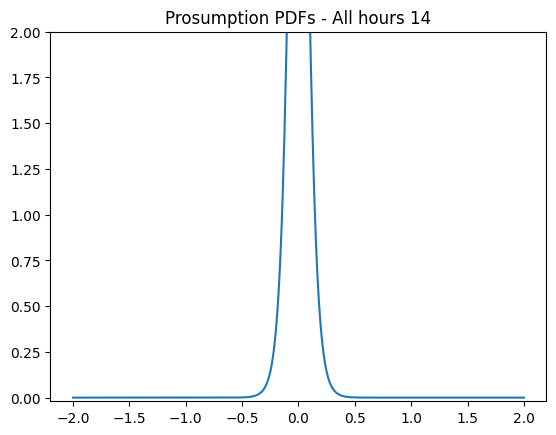

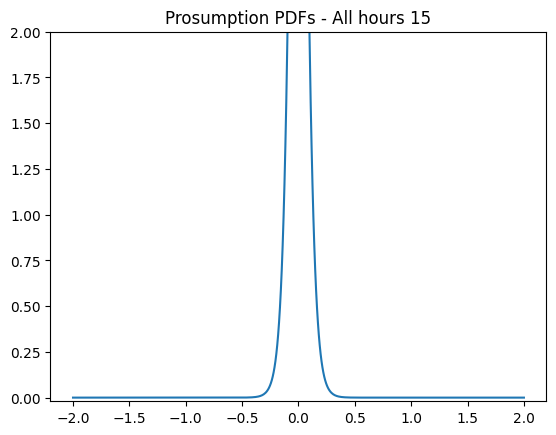

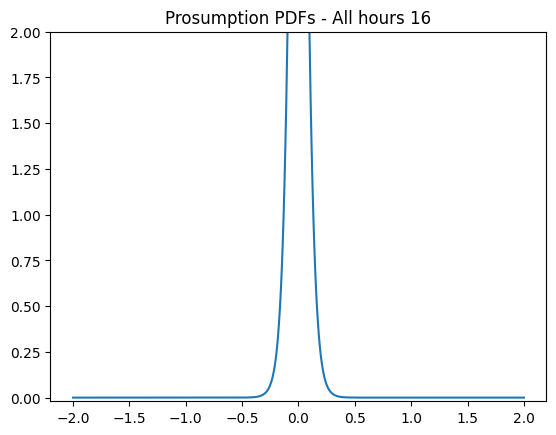

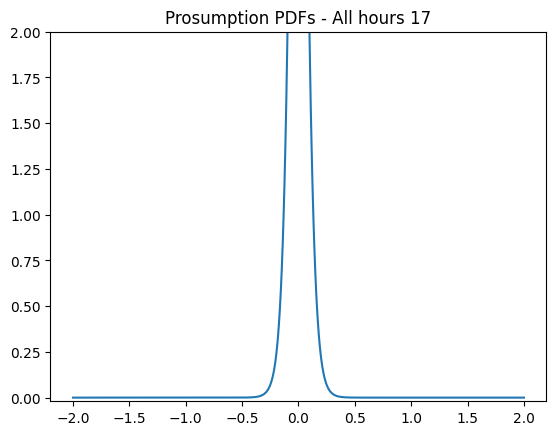

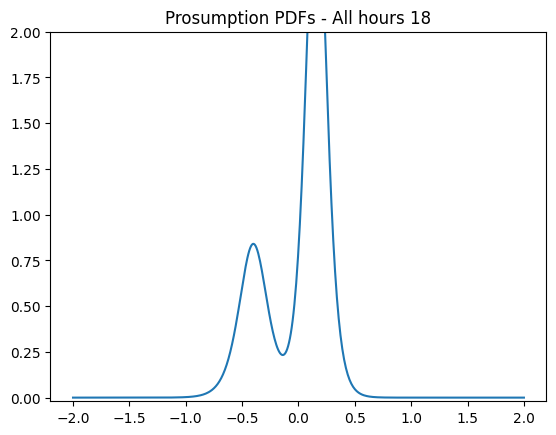

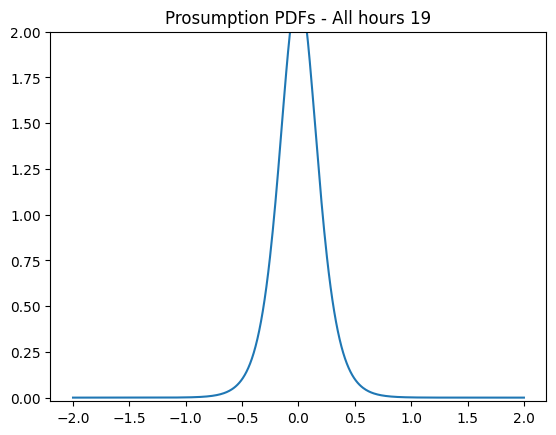

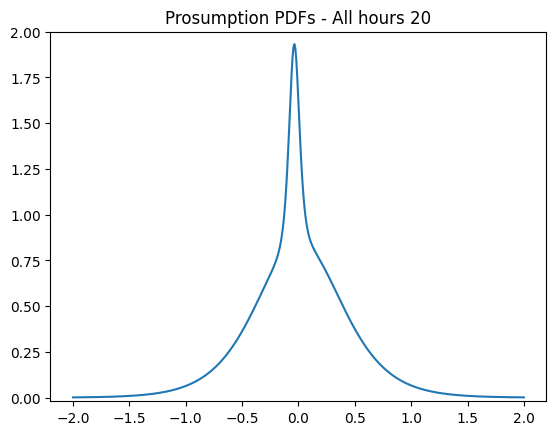

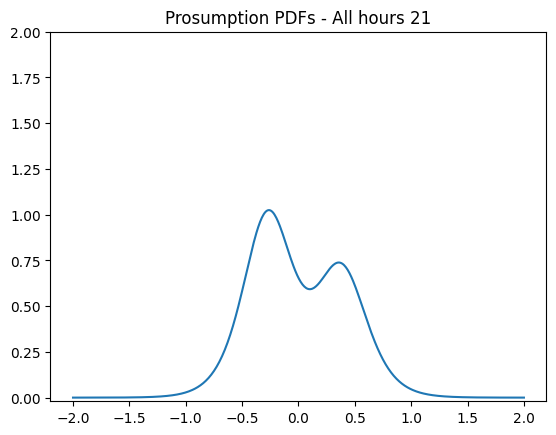

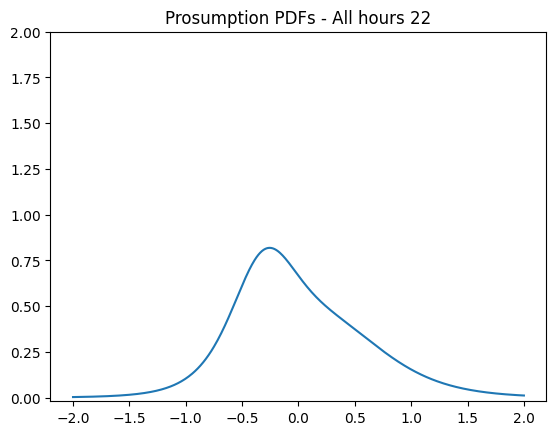

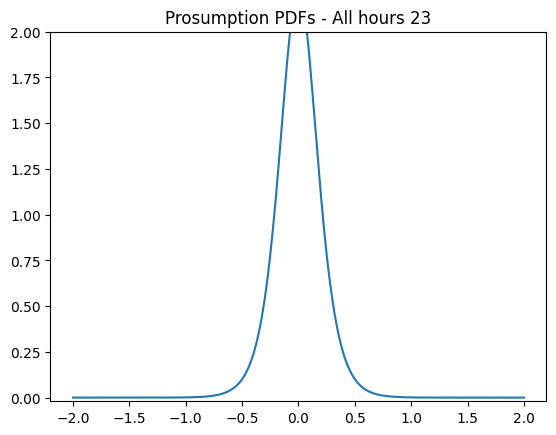

In [11]:
# Fit new pdfs to the shifted and normalized data to get weights for the pyomo model that can be used without having to divide by the integral
weights_final = []
x_data = np.linspace(-5, 5, 200)
for h in range(0, 24):
    y_data = sum_of_logistics_pdf_normalized(x_data, *weights_normalized_shifted[h])
    weights_final_h, _ = curve_fit(sum_2_logistic_pdf, x_data, y_data, maxfev=50000)
    weights_final.append(weights_final_h)

# Plot the fitted, normalized and SHIFTED pdfs
x_data = np.linspace(-2, 2, 500)
for h in range(0, 24):
    y_data = sum_2_logistic_pdf(x_data, *weights_final[h])
    plt.plot(x_data, y_data)
    plt.ylim(-0.02, 2)
    plt.title(f"Prosumption PDFs - All hours {h}")
    plt.show()

In [12]:
# Check if the fitted pdfs integrate to one and have an expected value of 0
for h in range(0, 24):
    expected_val = quad(lambda x: x * sum_2_logistic_pdf(x, *weights_final[h]), -10, 10)[0]
    integral, _ = quad(lambda x: sum_2_logistic_pdf(x, *weights_final[h]), -10, 10)
    print(f"Hour {h}: Expected Value={expected_val} Total Probability={integral}")

Hour 0: Expected Value=-3.991717840957287e-10 Total Probability=1.000000000190592
Hour 1: Expected Value=-3.991717840957287e-10 Total Probability=1.000000000190592
Hour 2: Expected Value=5.016820292524926e-15 Total Probability=0.9999999999999998
Hour 3: Expected Value=8.116381540745898e-07 Total Probability=1.0000000000000002
Hour 4: Expected Value=8.644973625848706e-12 Total Probability=1.0
Hour 5: Expected Value=-3.991717840957287e-10 Total Probability=1.000000000190592
Hour 6: Expected Value=3.7393699248156054e-14 Total Probability=1.0000000000000002
Hour 7: Expected Value=-1.415618183667756e-12 Total Probability=0.9999999998505675
Hour 8: Expected Value=-1.0095837710250975e-11 Total Probability=1.000000000010167
Hour 9: Expected Value=1.4356571487184056e-14 Total Probability=1.0000000000000007
Hour 10: Expected Value=-1.5099387865904503e-12 Total Probability=0.9999999995367513
Hour 11: Expected Value=-1.5099387865904503e-12 Total Probability=0.9999999995367513
Hour 12: Expected Val

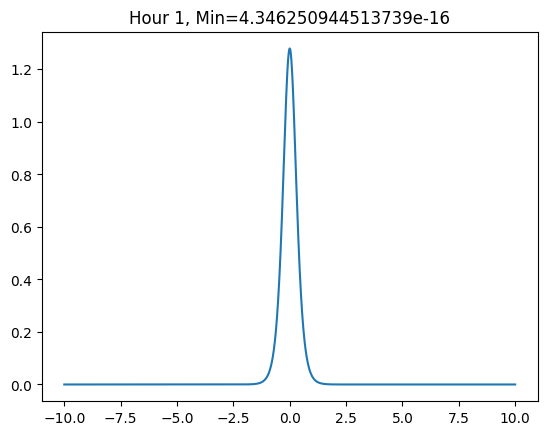

In [13]:
# Plot the fitted, normalized and UNSIHFTED pdfs
x_data = np.linspace(-10, 10, 10000)
y_data = sum_2_logistic_pdf(x_data, *weights_final[1])
y_min = np.min(y_data)
plt.plot(x_data, y_data)
plt.title(f"Hour {1}, Min={y_min}")
plt.show()

C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\517292270.py:3: RuntimeWarning: overflow encountered in exp
  return w1 / (1 + np.exp(-w2 * (x - w3))) + w4 / (1 + np.exp(-w5 * (x - w6)))
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\517292270.py:14: OptimizeWarning: Covariance of the parameters could not be estimated
  weights, _ = curve_fit(sum_2_logistic_cdf, power_quantiles, probabilities, maxfev=50000)
C:\Users\fh6281\AppData\Local\Temp\ipykernel_21612\517292270.py:6: RuntimeWarning: overflow encountered in scalar power
  return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2


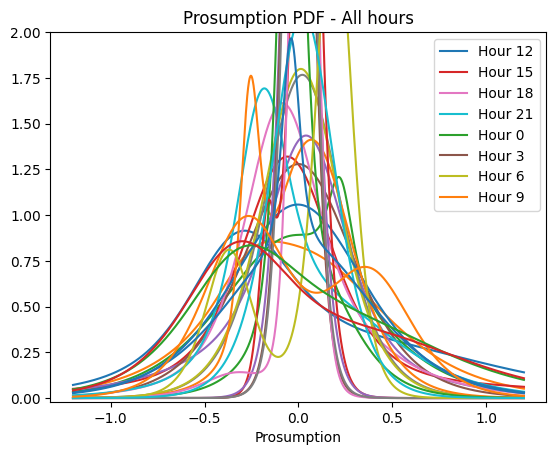

In [14]:
# Preprare usage of sum of 2 logistic functions for the prosumption
def sum_2_logistic_cdf(x, w1, w2, w3, w4, w5, w6):
    return w1 / (1 + np.exp(-w2 * (x - w3))) + w4 / (1 + np.exp(-w5 * (x - w6)))

def sum_2_logistic_pdf(x, w1, w2, w3, w4, w5, w6):
    return w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2 + w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2

probabilities = np.linspace(0.01, 0.99, 99)
logistic_weights = []
for h in range(0, 24):
    power_quantiles = power_fc.iloc[:99, h].values

    # Fit the sum of 2 logistic functions to the data
    weights, _ = curve_fit(sum_2_logistic_cdf, power_quantiles, probabilities, maxfev=50000)
    if h == 5: 
        weights = [0.99967495, 5.117566, 0.72800567, 0.0, 0.0, 0.0] # use single logistic function here instead -> weird outlier outside of the range
    if h == 7: 
        weights = [0.97455708, 7.25075964, 0.81333605, 0.0, 0.0, 0.0]
    if h == 8:
        weights = [0.98482503, 7.30661912, 0.84453286, 0.0, 0.0, 0.0] # use single logistic function here instead -> double does not converge
    if h == 10:
        weights = [1.00334229, 4.21623847, 1.1167537, 0.0, 0.0, 0.0]
    if h == 14:
        weights = [0.99405916, 19.66994906, 0.43363253, 0.0, 0.0, 0.0]
    if h == 15:
        weights = [1.00165363, 23.18201043, 0.44108622, 0.0, 0.0, 0.0]
    if h == 17:
        weights = [0.98916701, 22.92670541, 0.46750456, 0.0, 0.0, 0.0]
    if h == 19:
        weights = [0.94455275, 8.91549959, 0.44368902, 0.0, 0.0, 0.0]
    logistic_weights.append(weights)

#test different weights if the op is still solvable
# copy = []
# for weights in logistic_weights:
#     copy.append(logistic_weights[10].copy()) # checked: 0,1,2,3,4,5,6,7,8,9, 11 (weird), 12,13,14,15,16,17,18(weird), 20(a bit like 19),21,22,23    not solvable: 10(invalid number in nlp func or derivative detected), 19(restoration failed)
# logistic_weights = copy



prosumption_logistic_realistic = []
logistic_weights_shifted = []
for h in range(0, 24):
    weights = logistic_weights[h].copy()
    expected_value = integrate.quad(lambda x: x * sum_2_logistic_pdf(x, *weights), -20, 20)[0]
    prosumption_logistic_realistic.append(expected_value)
    #print(f"Hour {h}: expected value={expected_value}")

    # shift the logistic functions by the expected value
    weights[2] -= expected_value
    weights[5] -= expected_value
    logistic_weights_shifted.append(weights)

# Check if the shifted expected values are zero
shifted_exp_values = []
for h in range(0, 24):
    exp_val = integrate.quad(lambda x: x * sum_2_logistic_pdf(x, *logistic_weights_shifted[h]), -20, 20)[0]
    shifted_exp_values.append(exp_val)



for h in range(0, 24):
    
    # plot the pdf of the sum of 2 logistic functions with the shifted weights
    #fig = plt.figure(figsize=(10, 6))
    x = np.linspace(-1.2, 1.2, 1000)
    y = sum_2_logistic_pdf(x, *logistic_weights_shifted[h])
    y_old = sum_2_logistic_pdf(x, *logistic_weights[h])
    #plt.plot(x, y_old,  label="old")
    plt.title(f"Prosumption PDF - All hours")
    if h < 12:
        hour_of_day = str(h+12)
    if h >= 12:
        hour_of_day = str(h-12)
    if hour_of_day == "12" or hour_of_day == "15" or hour_of_day == "18" or hour_of_day == "21" or hour_of_day == "0" or hour_of_day == "3" or hour_of_day == "6" or hour_of_day == "9":
        plt.plot(x, y, label=f"Hour {hour_of_day}")
    else:
        plt.plot(x, y)
    #plt.title(f"Forecast Prosumption PDF - Hour of Day: {hour_of_day}")
    plt.xlabel("Prosumption")
    plt.ylim(-0.02, 2)
    plt.grid()
    plt.legend()
    #plt.show()




In [15]:
total_probs_2_logistics = []
for h in range(0, 24):
    total_prob = integrate.quad(lambda x: sum_2_logistic_pdf(x, *logistic_weights_shifted[h]), -10, 10)[0]
    total_probs_2_logistics.append(total_prob)

total_probs_2_logistics

[1.0861646615712661,
 0.9811749605794102,
 0.9798196129712815,
 1.055317651808625,
 1.0120804709738636,
 0.9996749499999993,
 1.026271853659486,
 0.9745570800000001,
 0.9848250300000002,
 1.0255863516441746,
 1.00334229,
 0.9790480415558165,
 0.9893192939269888,
 0.9526889791280979,
 0.9940591599999994,
 1.00165363,
 0.986853300080844,
 0.9891670100000001,
 0.9650482541405202,
 0.9445527500000004,
 1.0177705790113445,
 0.9711533942660597,
 1.019878087458112,
 0.998544424283498]

In [16]:
weights_1 = [ 0.60179745,  2.04017814,  0.08641232,  0.48436721,  5.71566668, -0.49439081]
exp_val_1 = integrate.quad(lambda x: x * sum_2_logistic_pdf(x, *weights_1), -20, 20)[0]
print("Expected unshifted val: ", exp_val_1)


weights_1_shifted = weights_1.copy()
weights_1_shifted[2] -= exp_val_1
weights_1_shifted[5] -= exp_val_1

exp_val_1_shifted = integrate.quad(lambda x: x * sum_2_logistic_pdf(x, *weights_1_shifted), -20, 20)[0]
print("Expected shifted val: ", exp_val_1_shifted)

Expected unshifted val:  -0.18746398346475493
Expected shifted val:  0.01615277039748504


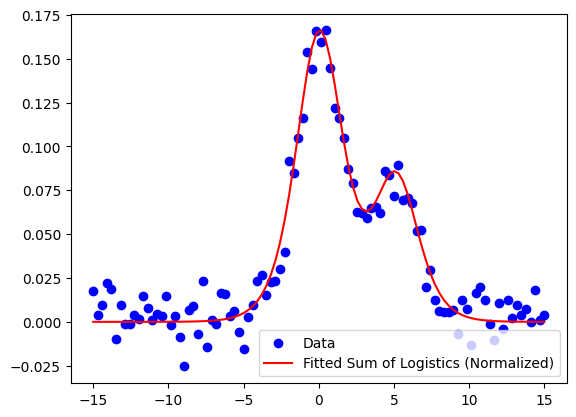

Total probability:  1.0


In [17]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Define the sum of two logistic functions, with a normalization factor
def sum_of_logistics_normalized(x, w1, w2, w3, w4, w5, w6):
    logistic1 = w1 * w2 * np.exp(-w2 * (x - w3)) / (1 + np.exp(-w2 * (x - w3)))**2  
    logistic2 = w4 * w5 * np.exp(-w5 * (x - w6)) / (1 + np.exp(-w5 * (x - w6)))**2  
    
    # Numerical integration over the range of x to compute the normalization factor
    integral, _ = quad(lambda t: w1 * w2 * np.exp(-w2 * (t - w3)) / (1 + np.exp(-w2 * (t - w3)))**2 + w4 * w5 * np.exp(-w5 * (t - w6)) / (1 + np.exp(-w5 * (t - w6)))**2, -10, 10 )
    
    # Return the sum normalized by the integral
    return (logistic1 + logistic2) / integral

# Generate some data for fitting (for example purposes)
x_data = np.linspace(-15, 15, 100)
y_data = sum_of_logistics_normalized(x_data, 1, 1, 0, 0.5, 1, 5) + 0.01 * np.random.normal(size=x_data.size)  # Add noise

# Fit the sum of two logistics to the data
initial_guess = [1, 1, 0, 0.5, 1, 5]  # Initial guesses for the parameters
popt, pcov = curve_fit(sum_of_logistics_normalized, x_data, y_data, p0=initial_guess)

# Generate the fitted curve
y_fitted = sum_of_logistics_normalized(x_data, *popt)

# Plot the data and the fit
plt.scatter(x_data, y_data, label="Data", color='blue')
plt.plot(x_data, y_fitted, label="Fitted Sum of Logistics (Normalized)", color='red')
plt.legend()
plt.show()


total_prob = integrate.quad(lambda x: sum_of_logistics_normalized(x, *popt), -10, 10)[0]
print("Total probability: ", total_prob)

In [18]:
weights_final[21]

array([ 0.58273537,  6.78072187, -0.27283115,  0.41726463,  6.60471362,
        0.38102526])

In [19]:
# Sample start date for demonstration
start_date = '1/1/2020 12:00:00'
pl_discretize_limit =   5.0 #pyo.sqrt((3/4)**(2/3))  # 5.0
t_inc = 1.0
e0 = 6.0
e_min = 0.0
e_max = 10.0
pb_min = -5.0
pb_max = 5.0
mu = 0.05
# Generate a prosumption forecast as a DataFrame
#prosumption_forecast = pd.DataFrame({'prosumption': np.random.normal(1, 1, 24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
#prosumption_forecast = pd.DataFrame({'prosumption': np.array([2]*24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
#prosumption_forecast = pd.DataFrame({'prosumption': 1.5 * np.sin(2 * np.pi * (np.arange(0, 24) - 6) / 24) + 1 + np.random.normal(0, 0.2, size=24)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
#prosumption_forecast = pd.DataFrame({'prosumption': np.array(prosumption_realistic)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
prosumption_forecast = pd.DataFrame({'prosumption': np.array(prosumption_logistic_realistic)}, index=pd.date_range(start=start_date, periods=24, freq='h'))
#prosumption_forecast = pd.DataFrame({'prosumption': np.array(pl_hat_realistic)}, index=pd.date_range(start=start_date, periods=24, freq='h'))


# Generate the CDF functions with different variances
#different_variances = 2 * np.random.beta(1, 1, 24) 
#different_variances = np.array([1.5]*10 + [1.0, 1.0, 1.0, 1.0] + [0.5]*10) 
#different_variances = np.array([2.0]*24) 
#different_variances = np.array([1]*8 + [0.5]*8 + [2]*8)  
#different_variances = np.array([2]*8 + [0.1]*8 + [0.8]*8) 
#different_variances = np.array([1.0]*24) 
#different_variances = np.array([0.8]*24) 
#different_variances = np.array([0.35]*24)
#different_variances = np.array([0.25]*24)
#different_variances = np.array([0.1]*24)
#different_variances = np.array([0.05]*24)
#different_variances = np.array([0.1]*8 + [0.5]*8 + [2.0]*8)
#different_variances = np.linspace(0.05, 3.0, 24)
#different_variances = -np.linspace(-3.0, -0.1, 24)

#different_variances = np.array(std_abweichung_realistic)
#different_weights = np.array(logistic_weights_shifted)
#different_weights = np.array([weights_final[22]]*12 + [weights_final[23]]*12)  # Klappt:  0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23      Klappt nicht: 1
#different_weights = np.array([weights_final[1]]*24)  
different_weights = np.array(weights_final)  
#different_weights = np.array([[0.99967495, 5.117566, 0.00023663824303354897, 0.0, 0.0, -0.7277690317569665]]*24) # use single logistic function here instead -> weird outlier outside of the range



# UNIFORM DISTRIBUTION
#cdf_approximations = lambda x, lb, ub: (x - lb) / (ub - lb)

# QUADRATIC DISTRIBUTION
#cdf_approximations = lambda x: -1/3 * x**3 + x * (3/4)**(2/3) + 1/2


# NORMAL DISTRIBUTION
# CDF approximation via Double Factorial (!!) (For formula see https://en.wikipedia.org/wiki/Normal_distribution) Sorry in advance, for everyone who wants to understand this >.<
#cdf_approximations = lambda x, mu, sig, n: 0.5 + 1/(2*pi)**0.5 * pyo.exp(-0.5 * ((x-mu)/sig)**2) * sum([((x-mu)/sig)**(i) / (pyo.prod(range(1, i+1, 2))) for i in range(1, 2*n, 2)])


# SUM OF 2 LOGISTIC FUNCTIONS
cdf_approximations = lambda x, w1, w2, w3, w4, w5, w6: w1 / (1 + pyo.exp(-w2 * (x - w3))) + w4 / (1 + pyo.exp(-w5 * (x - w6)))


# SUM OF 2 NORMAL DISTRIBUTIONS
#cdf_approximations = lambda x, mu1, sig1, mu2, sig2, n: 0.5 + 1/(2*pi)**0.5 * pyo.exp(-0.5 * ((x-mu1)/sig1)**2) * sum([((x-mu1)/sig1)**(i) / (pyo.prod(range(1, i+1, 2))) for i in range(1, 2*n, 2)])





# Create a ConcreteModel
op = pyo.ConcreteModel()

# Pyomo Sets
op.time = pyo.Set(initialize=prosumption_forecast.index)
op.time_e = pyo.Set(dimen=1, initialize=prosumption_forecast.index.append(pd.Index([prosumption_forecast.index[-1] + prosumption_forecast.index.freq])))
op.time_e0 = pyo.Set(dimen=1, initialize=prosumption_forecast.index.to_list()[:1])
op.weight_index = pyo.Set(initialize=list(range(6)))


# Pyomo Params
op.pl = pyo.Param(op.time, initialize=prosumption_forecast['prosumption'].to_dict())
op.e0 = pyo.Param(op.time_e0, initialize=e0)
#op.different_variances = pyo.Param(op.time, initialize={t: different_variances[i] for i, t in enumerate(op.time)})
op.different_weights = pyo.Param(op.time, initialize={t: different_weights[i] for i, t in enumerate(op.time)}, domain=pyo.Any) # maybe set dimensionality needs to be increased here => with time 7 dimensional

# weights_dict = {}
# for i, time in enumerate(op.time):
#     for j, weight_idx in enumerate(op.weight_index):
#         weights_dict[(time, weight_idx)] = different_weights[i][j]
# op.different_weights = pyo.Param(op.time, op.weight_index, initialize=weights_dict)


# Pyomo Decision Variables
op.e = pyo.Var(op.time_e, domain=pyo.Reals)
op.e_dv = pyo.Var(op.time_e, domain=pyo.Reals)
op.delta_e_min = pyo.Var(op.time_e, domain=pyo.NonPositiveReals)
op.delta_e_max = pyo.Var(op.time_e, domain=pyo.NonNegativeReals)

op.pg = pyo.Var(op.time, domain=pyo.Reals)
op.pg_plus = pyo.Var(op.time, domain=pyo.NonNegativeReals)
op.pg_minus = pyo.Var(op.time, domain=pyo.NonPositiveReals)

op.pb = pyo.Var(op.time, domain=pyo.Reals)
op.pb_dv = pyo.Var(op.time, domain=pyo.Reals)
op.pb_dv_plus = pyo.Var(op.time, domain=pyo.NonNegativeReals)  # Contributes to Discharging
op.pb_dv_minus = pyo.Var(op.time, domain=pyo.NonPositiveReals) # Contributes to Charging

op.pb_tilde = pyo.Var(op.time, domain=pyo.Reals)
op.pb_tilde_plus = pyo.Var(op.time, domain=pyo.NonNegativeReals)  # Contributes to Discharging
op.pb_tilde_minus = pyo.Var(op.time, domain=pyo.NonPositiveReals) # Contributes to Charging


op.x_low = pyo.Var(op.time, domain=pyo.Reals, bounds=(-pl_discretize_limit, 0)) # todo: make these bounds dynamic and dont use linspace. Vals near zero are more important
op.x_high = pyo.Var(op.time, domain=pyo.Reals, bounds=(0, pl_discretize_limit))

op.prob1 = pyo.Var(op.time, domain=pyo.NonNegativeReals, bounds=(0, 1))
op.prob2 = pyo.Var(op.time, domain=pyo.NonNegativeReals, bounds=(0, 1))

op.integral = pyo.Var(op.time, domain=pyo.Reals)

op.exp_delta_pg_low = pyo.Var(op.time, domain=pyo.Reals)
op.exp_delta_pg_high = pyo.Var(op.time, domain=pyo.Reals)



# # Uniform/Quadratic distribution test case
# def constr_x_low(model, time):
#    return model.x_low[time] == -2#-3.0#-0.4#-2#-0.6#
# op.constr_x_low = pyo.Constraint(op.time, rule=constr_x_low)

# def constr_x_high(model, time):
#    return model.x_high[time] == 0.5#1.0#0.2#1.0
# op.constr_x_high = pyo.Constraint(op.time, rule=constr_x_high)



# todo: replace different_variances to always use the correct variance for the current time step
def constr_prob1(model, time):
    #return model.prob1[time] == cdf_approximations(model.x_low[time], 0, model.different_variances[time], 60) #30      # normal distribution
    return model.prob1[time] == cdf_approximations(model.x_low[time], *model.different_weights[time])             # 2 logistic functions
    #return model.prob1[time] == cdf_approximations(model.x_low[time], -pl_discretize_limit, pl_discretize_limit)   # uniform distribution
    #return model.prob1[time] == cdf_approximations(model.x_low[time])                                               # quadratic distribution
op.constr_prob1 = pyo.Constraint(op.time, rule=constr_prob1)

def constr_prob2(model, time):
    #return model.prob2[time] == 1 - cdf_approximations(model.x_high[time], 0, model.different_variances[time], 60) #30     # normal distribution
    return model.prob2[time] == 1 - cdf_approximations(model.x_high[time], *model.different_weights[time])             # 2 logistic functions
    #return model.prob2[time] == 1 - cdf_approximations(model.x_high[time], -pl_discretize_limit, pl_discretize_limit)  # uniform distribution
    #return model.prob2[time] == 1 - cdf_approximations(model.x_high[time])                                              # quadratic distribution
op.constr_prob2 = pyo.Constraint(op.time, rule=constr_prob2)



# todo: rename integral_low to exp_delta_pb_low
def constr_integral(model, time):
    #sig = model.different_variances[time]
    #return model.integral[time] == simpsons_rule_normal(model.x_low[time], model.x_high[time], 2000, sig, offset=0)                      # normal distribution
    return model.integral[time] == simpsons_rule_2_logistic(model.x_low[time], model.x_high[time], 300, *model.different_weights[time], offset=0)     # 2 logistic functions
    #return model.integral[time] == simpsons_rule_uniform(model.x_low[time], model.x_high[time], 200, -pl_discretize_limit, pl_discretize_limit)     # uniform distribution
    #return model.integral[time] == simpsons_rule_quadratic(model.x_low[time], model.x_high[time], 200, offset=0)                                     # quadratic distribution
op.constr_integral = pyo.Constraint(op.time, rule=constr_integral)

# def constr_integral_high(model, time):
#     sig = model.different_variances[time]
#     return model.integral_high[time] == 0#simpsons_rule_normal(0, model.x_high[time], 100, sig, offset=0)                       # normal distribution
#     #return model.integral_high[time] == simpsons_rule_uniform(0, model.x_high[time], 100, -pl_discretize_limit, pl_discretize_limit)   # uniform distribution
#     #return model.integral_high[time] == simpsons_rule_quadratic(0, model.x_high[time], 100, offset=0)                                   # quadratic distribution
# op.constr_integral_high = pyo.Constraint(op.time, rule=constr_integral_high)



def constr_exp_delta_pg_low(model, time):
    #sig = model.different_variances[time]  # todo: shouldnt the integral go from -inf to 0 for pg?
    #return model.exp_delta_pg_low[time] == simpsons_rule_normal(-15, 0, 2000, sig, offset=model.x_low[time]) #/ model.prob1[time]  # todo: Change the lower bound to -inf or ensure that it is big enough. However, also ensure that the points are sufficient (depends on the limit)
    return model.exp_delta_pg_low[time] == simpsons_rule_2_logistic(-5, 0, 300, *model.different_weights[time], offset=model.x_low[time])  # 2 logistic functions
    #return model.exp_delta_pg_low[time] == simpsons_rule_uniform(-pl_discretize_limit - model.x_low[time], 0, 100, -pl_discretize_limit, pl_discretize_limit) # uniform distribution
    #return model.exp_delta_pg_low[time] == simpsons_rule_quadratic(-pl_discretize_limit - model.x_low[time], 0, 100, offset=model.x_low[time])                  # quadratic distribution
op.constr_exp_delta_pg_low = pyo.Constraint(op.time, rule=constr_exp_delta_pg_low)

def constr_exp_delta_pg_high(model, time):
    #sig = model.different_variances[time]
    #return model.exp_delta_pg_high[time] == simpsons_rule_normal(0, 15, 2000, sig, offset=model.x_high[time]) # / model.prob2[time]                                            # normal distribution
    return model.exp_delta_pg_high[time] == simpsons_rule_2_logistic(0, 5, 300, *model.different_weights[time], offset=model.x_high[time])  # 2 logistic functions
    #return model.exp_delta_pg_high[time] == simpsons_rule_uniform(0, pl_discretize_limit - model.x_high[time], 100, -pl_discretize_limit, pl_discretize_limit)    # uniform distribution
    #return model.exp_delta_pg_high[time] == simpsons_rule_quadratic(0, pl_discretize_limit - model.x_high[time], 100, offset=model.x_high[time])                    # quadratic distribution
op.constr_exp_delta_pg_high = pyo.Constraint(op.time, rule=constr_exp_delta_pg_high)



def constr_pg_split(model, time):
    return model.pg[time] == model.pg_plus[time] + model.pg_minus[time]
op.constr_pg_split = pyo.Constraint(op.time, rule=constr_pg_split)

def constr_pg_relax(model, time):
    return (-1e-8, model.pg_plus[time] * model.pg_minus[time], 0)
op.constr_pg_relax = pyo.Constraint(op.time, rule=constr_pg_relax)



def constr_pb_dv_split(model, time):
    return model.pb_dv[time] == model.pb_dv_plus[time] + model.pb_dv_minus[time]
op.constr_pb_dv_split = pyo.Constraint(op.time, rule=constr_pb_dv_split)

def constr_pb_dv_relax(model, time):
    return (-1e-8, model.pb_dv_plus[time] * model.pb_dv_minus[time], 0)
op.constr_pb_dv_relax = pyo.Constraint(op.time, rule=constr_pb_dv_relax) 



def constr_pb_tilde(model, time):
    return model.pb_tilde[time] == model.integral[time] + model.prob1[time] * model.x_low[time] + model.prob2[time] * model.x_high[time]  # This equations is not affine => Non-Convex problem
op.constr_pb_tilde = pyo.Constraint(op.time, rule=constr_pb_tilde)


def constr_pb_tilde_split(model, time):
    return model.pb_tilde[time] == model.pb_tilde_plus[time] + model.pb_tilde_minus[time]
op.constr_pb_tilde_split = pyo.Constraint(op.time, rule=constr_pb_tilde_split)

def constr_pb_tilde_relax(model, time):
    return (-1e-8, model.pb_tilde_plus[time] * model.pb_tilde_minus[time], 0)
op.constr_pb_tilde_relax = pyo.Constraint(op.time, rule=constr_pb_tilde_relax)





def constr_e_evolution(model, time):
    if time == model.time_e.first():
        return model.e[time] == model.e0[time]
    else:
        prev_time = model.time_e.prev(time)
        return model.e[time] == model.e[prev_time] - t_inc * model.pb_dv[prev_time] - t_inc * model.pb_tilde[prev_time] + t_inc * mu * (-model.pb_dv_plus[prev_time] + model.pb_dv_minus[prev_time] - model.pb_tilde_plus[prev_time] + model.pb_tilde_minus[prev_time])
op.constr_e_evolution = pyo.Constraint(op.time_e, rule=constr_e_evolution)

def constr_e_dv_evolution(model, time):
    if time == model.time_e.first():
        return model.e_dv[time] == model.e0[time]
    else:
        prev_time = model.time_e.prev(time)
        return model.e_dv[time] == model.e_dv[prev_time] - t_inc * model.pb_dv[prev_time] + t_inc * mu * (-model.pb_dv_plus[prev_time] + model.pb_dv_minus[prev_time])
op.constr_e_dv_evolution = pyo.Constraint(op.time_e, rule=constr_e_dv_evolution)


def constr_delta_e_min(model, time):
    if time == model.time_e.first():
        return model.delta_e_min[time] == 0.0
    else:
        prev_time = model.time_e.prev(time)
        #return model.delta_e_min[time] == model.delta_e_min[prev_time] - t_inc * model.x_high[prev_time] + t_inc * model.pb_tilde[prev_time] + t_inc * mu * (-model.x_high[prev_time] - model.pb_tilde_plus[prev_time] + model.pb_tilde_minus[prev_time])
        #return model.delta_e_min[time] == model.delta_e_min[prev_time] - t_inc * model.x_high[prev_time] + t_inc * model.pb_tilde[prev_time] + t_inc * mu * (-model.x_high[prev_time] + model.pb_tilde_plus[prev_time] - model.pb_tilde_minus[prev_time])
        return model.delta_e_min[time] == model.delta_e_min[prev_time] - t_inc * model.x_high[prev_time] - t_inc * mu * model.x_high[prev_time]
op.constr_delta_e_min = pyo.Constraint(op.time_e, rule=constr_delta_e_min)



def constr_delta_e_max(model, time):
    if time == model.time_e.first():
        return model.delta_e_max[time] == 0.0
    else:
        prev_time = model.time_e.prev(time)
        #return model.delta_e_max[time] == model.delta_e_max[prev_time] - t_inc * model.x_low[prev_time] + t_inc * model.pb_tilde[prev_time] + t_inc * mu * (+model.x_low[prev_time] - model.pb_tilde_plus[prev_time] + model.pb_tilde_minus[prev_time])
        #return model.delta_e_max[time] == model.delta_e_max[prev_time] - t_inc * model.x_low[prev_time] + t_inc * model.pb_tilde[prev_time] + t_inc * mu * (+model.x_low[prev_time] + model.pb_tilde_plus[prev_time] - model.pb_tilde_minus[prev_time])
        return model.delta_e_max[time] == model.delta_e_max[prev_time] - t_inc * model.x_low[prev_time] + t_inc * mu * model.x_low[prev_time]
op.constr_delta_e_max = pyo.Constraint(op.time_e, rule=constr_delta_e_max)



def constr_e_limit_min(model, time):
    return model.e_dv[time] + model.delta_e_min[time] >= e_min
op.constr_e_limit_min = pyo.Constraint(op.time_e, rule=constr_e_limit_min)

def constr_e_limit_max(model, time):
    return model.e_dv[time] + model.delta_e_max[time] <= e_max
op.constr_e_limit_max = pyo.Constraint(op.time_e, rule=constr_e_limit_max)



def constr_pb_limit_min(model, time):
    return model.pb_dv[time] + model.x_low[time] >= pb_min
op.constr_pb_limit_min = pyo.Constraint(op.time, rule=constr_pb_limit_min)

def constr_pb_limit_max(model, time):
    return model.pb_dv[time] + model.x_high[time] <= pb_max
op.constr_pb_limit_max = pyo.Constraint(op.time, rule=constr_pb_limit_max)


def constr_pb(model, time):
    return model.pb[time] == model.pb_dv[time] + model.pb_tilde[time]
op.constr_pb = pyo.Constraint(op.time, rule=constr_pb)


def constr_power_balance(model, time):
    return model.pg[time] == model.pl[time] - model.pb_dv[time]  # Choose if you want to use pb or pb_dv to get pg or pg_dv as result
op.constr_power_balance = pyo.Constraint(op.time, rule=constr_power_balance)



# def constr_test1(model,time):
#     return model.x_low[time] == 0.0
# op.constr_test1 = pyo.Constraint(op.time, rule=constr_test1)

# def constr_test2(model,time):
#     return model.x_high[time] == 0.0
# op.constr_test2 = pyo.Constraint(op.time, rule=constr_test2)



c1 = 1.0
c2 = 1.0
c3 = 1.0

c11 = 2.0  # buy
c12 = 0.0
c21 = 1.0  # sell
c22 = 0.0
c31 = 4.0  # deviation cost buy
c32 = 2.0  # deviation cost sell

last_time_e = op.time_e.last()
c_energy_final = 0.1

c_varying = {}
for t in op.time:
    if t == op.time.at(3):
        c_varying[t] = 2000.0
    else:
        c_varying[t] = 2.0
    
op.c31_varying = pyo.Param(op.time, initialize=c_varying)

c_buy = 1.0
c_sell = 1.0

# Define an example objective function
def objective_rule(model):
    #return sum(c1*model.pg[t] - c2 * model.prob1[t] * model.exp_delta_pg_low[t] + c3 * model.prob2[t] * model.exp_delta_pg_high[t] for t in model.time)
    #return sum(c1*model.pg[t] - c2*model.exp_delta_pg_low[t] + c3*model.exp_delta_pg_high[t] for t in model.time)
    #return sum(c1*model.pg[t] + c2*model.prob1[t] + c3*model.prob2[t] for t in model.time)
    #return sum(c1 * model.pg[t] * model.pg[t] for t in model.time )
    #return sum(c1 * (model.pg[t]) for t in model.time )
    #return sum(-c2 * model.exp_delta_pg_low[t] + c3 * model.exp_delta_pg_high[t] for t in model.time)
    #return sum(-c2 * model.exp_delta_pg_low[t] * model.prob1[t] + c3 * model.exp_delta_pg_high[t] * model.prob2[t] for t in model.time)
    #return sum(model.prob1[t] + model.prob2[t] for t in model.time)
    #return sum(- c2*model.exp_delta_pg_low[t] + c3*model.exp_delta_pg_high[t] for t in model.time)
    #return sum(c1 * model.pg[t] * model.pg[t] - c2 * model.prob1[t] * model.exp_delta_pg_low[t] + c3 * model.prob2[t] * model.exp_delta_pg_high[t] for t in model.time )
    #return sum(c1 * model.pg[t] **2 for t in model.time)
    #return sum(c1 * model.pg[t] * model.pg[t] for t in model.time)
    # return sum(c11 * c_buy * model.pg_plus[t] * model.pg_plus[t] + c12 * c_buy * model.pg_plus[t] + 
    #            c21 * c_sell * model.pg_minus[t] * model.pg_minus[t] + c22 * c_sell * model.pg_minus[t] + 
    #            c31 * c_buy * model.prob2[t] * model.exp_delta_pg_high[t] + 
    #            -c32 * c_sell * model.prob1[t] * model.exp_delta_pg_low[t] for t in model.time)
    # return sum(c11 * c_buy * model.pg_plus[t] * model.pg_plus[t]  + 
    #            c21 * c_sell * model.pg_minus[t] * model.pg_minus[t] + 
    #            c31 * c_buy * model.prob2[t] * model.exp_delta_pg_high[t] + 
    #            -c32 * c_sell * model.prob1[t] * model.exp_delta_pg_low[t] for t in model.time)
    return c_energy_final * (model.e[last_time_e] - e_max/2)**2 +  sum(c11 * c_buy * model.pg_plus[t] * model.pg_plus[t]  + 
               c21 * c_sell * model.pg_minus[t] * model.pg_minus[t] + 
               c31 * c_buy * model.prob2[t] * model.exp_delta_pg_high[t] + 
               -c32 * c_sell * model.prob1[t] * model.exp_delta_pg_low[t] for t in model.time)
    # return sum(c11 * c_buy * model.pg_plus[t] * model.pg_plus[t]  + 
    #            c21 * c_sell * model.pg_minus[t] * model.pg_minus[t] + 
    #            model.c31_varying[t] * c_buy * model.prob2[t] * model.exp_delta_pg_high[t] + 
    #            -c32 * c_sell * model.prob1[t] * model.exp_delta_pg_low[t] for t in model.time)
    #return sum(c11 * c_buy * model.pg[t] * model.pg[t] + c31 * c_buy * model.prob2[t] * model.exp_delta_pg_high[t] - c32 * c_buy * model.prob1[t] * model.exp_delta_pg_low[t] for t in model.time)




op.obj = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the model
solver = pyo.SolverFactory('ipopt')
solver.options['max_iter'] = 5000
result = solver.solve(op, tee=True)

Ipopt 3.11.1: max_iter=5000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1204
Number of nonzeros in inequality constraint Jacobian.:      340
Number of nonzeros in Lagrangian Hessian.............:      289

Total number of variables............................:      508
                     variables with only lower bounds:       97
                variables with lower and upper bou

In [20]:
op.obj.display()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 6.669334371507985


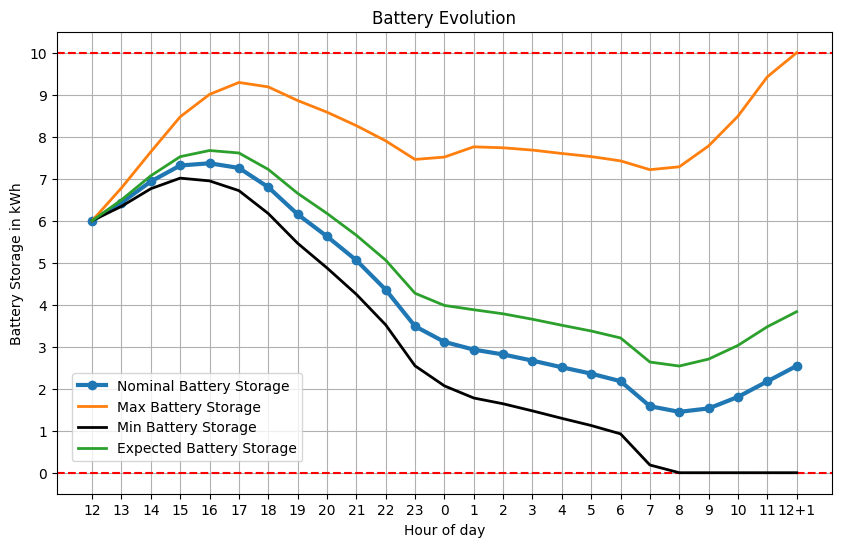

In [21]:
# Get the values from op.e
e_values = [op.e[t].value for t in op.time_e]
# Get the SoC values based of pb_dv
e_dv_values = [op.e_dv[t].value for t in op.time_e]
    

delta_e_max_vals = [op.delta_e_max[t].value for t in op.time_e]
delta_e_min_vals = [op.delta_e_min[t].value for t in op.time_e]
e_max_vals = [e_det + e_prob for e_det, e_prob in zip(e_dv_values, delta_e_max_vals)]
e_min_vals = [e_det + e_prob for e_det, e_prob in zip(e_dv_values, delta_e_min_vals)]



# Get the index values
index_values = range(len(e_values))
hours_of_day = []
count = 0
for val in index_values:
    if val < 12:
        hours_of_day.append(str(val + 12))
    
    if val == 24:
        hours_of_day.append('12+1')
        continue

    if val >= 12:
        hours_of_day.append(str(val - 12))

# Plot the values
fig = plt.figure(figsize=(10, 6))
plt.axhline(y=e_max, color='red', linestyle='--')
plt.axhline(y=e_min, color='red', linestyle='--')
plt.plot(hours_of_day, e_dv_values, 'o-',  linewidth=3, label='Nominal Battery Storage')
plt.plot(hours_of_day, e_max_vals, linewidth=2, label='Max Battery Storage')
plt.plot(hours_of_day, e_min_vals,color='black', linewidth=2, label='Min Battery Storage')
plt.plot(hours_of_day, e_values, linewidth=2, label='Expected Battery Storage')
plt.xlabel('Hour of day')
plt.ylabel('Battery Storage in kWh')
plt.title('Battery Evolution')
plt.grid()
plt.xticks(np.arange(0,25,1))
plt.yticks(np.arange(0,11,1))
plt.legend(loc=(0.02, 0.07))
plt.show()

## Other Stuff

In [26]:
x = op.time.ordered_data()

In [28]:
type(x[0])

pandas._libs.tslibs.timestamps.Timestamp

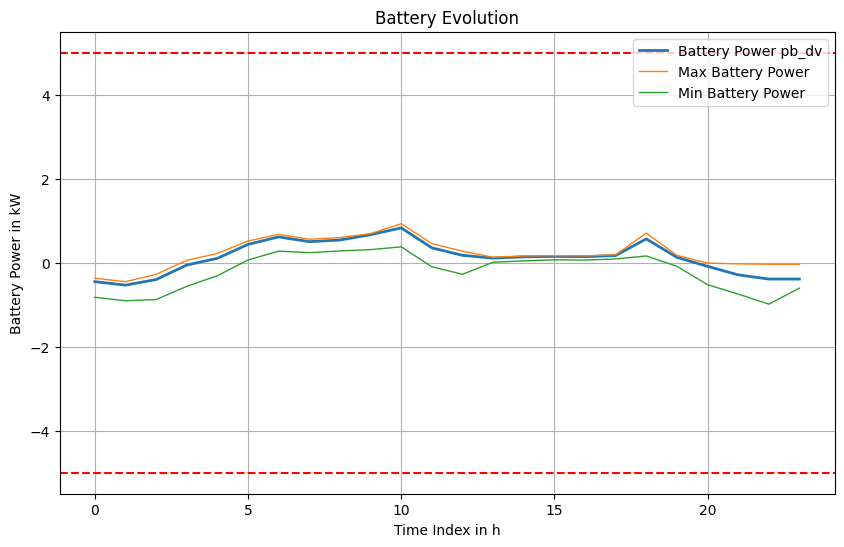

In [346]:
# Get the values from op.e
pb_values = [op.pb_dv[t].value for t in op.time]

total_pb_max_vals = [op.pb_dv[t].value + op.x_high[t].value for t in op.time]
total_pb_min_vals = [op.pb_dv[t].value + op.x_low[t].value for t in op.time]
# e_max_vals = [e_det + e_prob for e_det, e_prob in zip(e_values, delta_e_max_vals)]
# e_min_vals = [e_det + e_prob for e_det, e_prob in zip(e_values, delta_e_min_vals)]



# Get the index values
index_values = range(len(pb_values))



# Plot the values
fig = plt.figure(figsize=(10, 6))
plt.axhline(y=pb_max, color='red', linestyle='--')
plt.axhline(y=pb_min, color='red', linestyle='--')
plt.plot(index_values, pb_values, linewidth=2, label='Battery Power pb_dv')
plt.plot(index_values, total_pb_max_vals, linewidth=1, label='Max Battery Power')
plt.plot(index_values, total_pb_min_vals, linewidth=1, label='Min Battery Power')
plt.xlabel('Time Index in h')
plt.ylabel('Battery Power in kW')
plt.title('Battery Evolution')
plt.grid()
plt.legend()
plt.show()

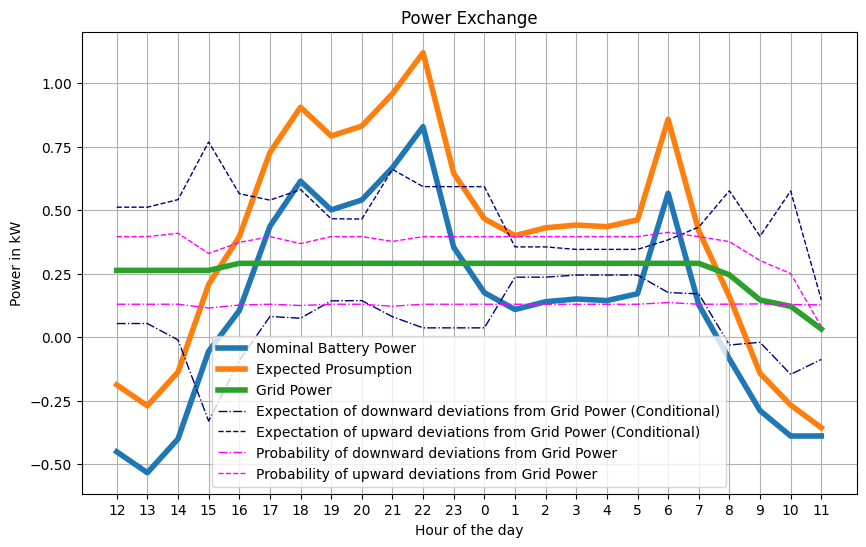

In [347]:
pg_vals = [op.pg[t].value for t in op.time]
pb_vals = [op.pb_dv[t].value for t in op.time]
pl_vals = [op.pl[t] for t in op.time]

pg_exp_low = [op.pg[t].value + op.exp_delta_pg_low[t].value for t in op.time]
pg_exp_high = [op.pg[t].value + op.exp_delta_pg_high[t].value for t in op.time]

pg_exp_low_conditional = [op.pg[t].value + op.exp_delta_pg_low[t].value / op.prob1[t].value for t in op.time]
pg_exp_high_conditional = [op.pg[t].value + op.exp_delta_pg_high[t].value / op.prob2[t].value for t in op.time]

prob_downward = [op.prob1[t].value for t in op.time]
prob_upward = [op.prob2[t].value for t in op.time]


index_values_p = list(range(len(pg_vals)))
for val in index_values_p:
    if val < 12:
        index_values_p[val] = str(val + 12)
    if val >= 12:
        index_values_p[val] = str(val - 12)

fig = plt.figure(figsize=(10, 6))
plt.plot(index_values_p, pb_vals, linewidth=4, label='Nominal Battery Power')
plt.plot(index_values_p, pl_vals, linewidth=4, label='Expected Prosumption')
plt.plot(index_values_p, pg_vals, linewidth=4, label='Grid Power')
#plt.plot(index_values_p, pg_exp_low, '-.', linewidth=1, label='Expectation of downward deviations from Grid Power', color='aqua')
#plt.plot(index_values_p, pg_exp_high, '--', linewidth=1, label='Expectation of upward deviations from Grid Power', color='aqua')
plt.plot(index_values_p, pg_exp_low_conditional, '-.', linewidth=1, label='Expectation of downward deviations from Grid Power (Conditional)', color='navy')
plt.plot(index_values_p, pg_exp_high_conditional, '--', linewidth=1, label='Expectation of upward deviations from Grid Power (Conditional)', color='navy')
plt.plot(index_values_p, prob_downward, '-.', linewidth=1, label='Probability of downward deviations from Grid Power', color='magenta')
plt.plot(index_values_p, prob_upward, '--', linewidth=1, label='Probability of upward deviations from Grid Power', color='magenta')
plt.xlabel('Hour of the day')
plt.ylabel('Power in kW')
plt.title('Power Exchange')
plt.legend()
plt.grid()
plt.show()

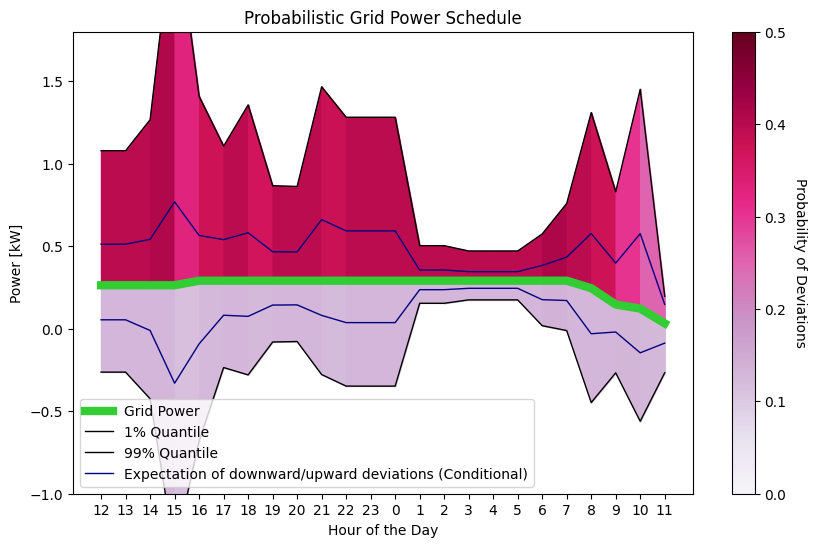

In [360]:
# Plot the probabilistic schedule in a nice format so people can understand it
times = [str(t.hour) for t in op.time]
pg_vals = [op.pg[t].value for t in op.time]


# Get the lines for 5% and 95% quantiles
from scipy.optimize import fsolve

quantile_low = 0.01
quantile_high = 0.99

# Compute the lower and upper quantile of the prosumption
prosumptions_low = []
prosumptions_high = []
for t in op.time:
    # Define new functions for the equation cdf_approximations(x) - target_output = 0
    func_to_solve_low = lambda x: sum_2_logistic_cdf(x, *op.different_weights[t]) - quantile_low
    func_to_solve_high = lambda x: sum_2_logistic_cdf(x, *op.different_weights[t]) - quantile_high

    initial_guess = 0.0

    solution_low = fsolve(func_to_solve_low, initial_guess)
    solution_high = fsolve(func_to_solve_high, initial_guess)

    prosumptions_low.append(solution_low)
    prosumptions_high.append(solution_high)

# Compute the truncated lower and upper quantile of the prosumption (i.e. the grid power uncertainty)
prosumption_05_zero_mean = []
prosumption_95_zero_mean = []
for i in range(len(prosumptions_low)):
    prosumption_05_quantile_temp = prosumptions_low[i] - op.x_low[op.time.at(i+1)].value
    prosumption_05_zero_mean.append(prosumption_05_quantile_temp)

    prosumption_95_quantile_temp = prosumptions_high[i] - op.x_high[op.time.at(i+1)].value
    prosumption_95_zero_mean.append(prosumption_95_quantile_temp)

# Shift the uncertainties to be the deviations from the nominal grid power
pg_05_quantile = [pg_norm + xxx for pg_norm, xxx in zip(pg_vals, prosumption_05_zero_mean)]
pg_95_quantile = [pg_norm + xxx for pg_norm, xxx in zip(pg_vals, prosumption_95_zero_mean)]




# Plot the expected grid power deviations. Do it conditional and unconditional. Maybe it should be cut off at 5 and 95% quantile?
# unconditional
pg_exp_low = [op.pg[t].value + op.exp_delta_pg_low[t].value for t in op.time]
pg_exp_high = [op.pg[t].value + op.exp_delta_pg_high[t].value for t in op.time]

# conditional
pg_exp_low_conditional = [op.pg[t].value + op.exp_delta_pg_low[t].value / op.prob1[t].value for t in op.time]
pg_exp_high_conditional = [op.pg[t].value + op.exp_delta_pg_high[t].value / op.prob2[t].value for t in op.time]
# => The conditional lines can exceed the 5% and 95% quantiles. This happens if the corresponding pdf only converges slowly to zero.
# => Either just dont show the conditional lines or increase the quantiles to eg. 1% and 99% quantiles



import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(times, pg_vals, label='Grid Power', color='limegreen', linewidth=6)
ax.plot(times, np.ravel(pg_05_quantile),label=f'{int(100*quantile_low)}% Quantile',  color='black', linewidth=1)
ax.plot(times, np.ravel(pg_95_quantile),label=f'{int(100*quantile_high)}% Quantile',  color='black', linewidth=1)
#plt.plot(times, pg_exp_low, label='Expectation downward deviations', color='aqua', linewidth=1)
#plt.plot(times, pg_exp_high, label='Expectation upward deviations', color='aqua', linewidth=1)
ax.plot(times, pg_exp_low_conditional, label='Expectation of downward/upward deviations (Conditional)', color='navy', linewidth=1)
ax.plot(times, pg_exp_high_conditional, color='navy', linewidth=1)
#plt.fill_between(times, np.ravel(pg_05_quantile), np.ravel(pg_95_quantile), color='grey', alpha=0.2)

cmap = plt.get_cmap('PuRd')
#cmap = plt.get_cmap('RdPu')
cmap2 = plt.get_cmap('Greens')
x = np.linspace(0, 24, 25)
probabilities = (np.cos(x) + 1) / 2  # Just a dummy example of probabilities
probs_low = list(op.prob1.get_values().values())
probs_high = list(op.prob2.get_values().values())

#norm = mcolors.Normalize(vmin=np.min(x), vmax=np.max(x))
#norm = mcolors.Normalize(vmin=np.min(probs_low), vmax=np.max(probs_low))
norm = mcolors.Normalize(vmin=0.0, vmax=0.5)


for i in range(len(times) - 1):
    #color_value = cmap(norm(x[i]))
    color_value = cmap(norm(probs_low[i]))
    color_value_high = cmap(norm(probs_high[i]))
    ax.fill_between(times[i:i+2], np.ravel(pg_vals)[i:i+2], np.ravel(pg_05_quantile)[i:i+2], color=color_value, alpha=1.0)
    #ax.fill_between(times[i:i+2], np.ravel(pg_vals)[i:i+2], np.ravel(pg_05_quantile)[i:i+2], color=cmap(probs_low[i]), alpha=1.0)
    ax.fill_between(times[i:i+2], np.ravel(pg_vals)[i:i+2], np.ravel(pg_95_quantile)[i:i+2], color=color_value_high, alpha=1.0)
    #ax.fill_between(times[i:i+2], np.ravel(pg_vals)[i:i+2], np.ravel(pg_95_quantile)[i:i+2], color=cmap(probs_high[i]), alpha=1.0)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Probability of Deviations', rotation=270, labelpad=15)


#plt.grid()
plt.legend()
plt.ylim(-1, 1.8)
plt.ylabel('Power [kW]')
plt.xlabel('Hour of the Day')
plt.title('Probabilistic Grid Power Schedule')
plt.show()





In [341]:
probs_high

[0.5000000002247448,
 0.5000000002247448,
 0.5223338127544701,
 0.4565512003104687,
 0.5352431015928831,
 0.5000000002247448,
 0.4520387117758648,
 0.4999999988570874,
 0.49999999945418205,
 0.4030506916452969,
 0.5000000002389501,
 0.5000000002389501,
 0.5000000002389501,
 0.5000000005142294,
 0.5000000005142294,
 0.5000000000932009,
 0.5000000000932009,
 0.5000000000932009,
 0.6675071820121684,
 0.4999999999844646,
 0.46883275130094,
 0.4652712701516697,
 0.44220358796370957,
 0.4999999999844646]

In [342]:
probs_low

[0.49999999977525533,
 0.49999999977525533,
 0.47766618724552984,
 0.5434487996895313,
 0.46475689840711687,
 0.49999999977525533,
 0.5479612882241353,
 0.5000000011429125,
 0.500000000545818,
 0.5969493083547031,
 0.49999999976105,
 0.49999999976105,
 0.49999999976105,
 0.49999999948577056,
 0.49999999948577056,
 0.4999999999067991,
 0.4999999999067991,
 0.4999999999067991,
 0.33249281798783165,
 0.5000000000155354,
 0.5311672486990601,
 0.5347287298483303,
 0.5577964120362904,
 0.5000000000155354]

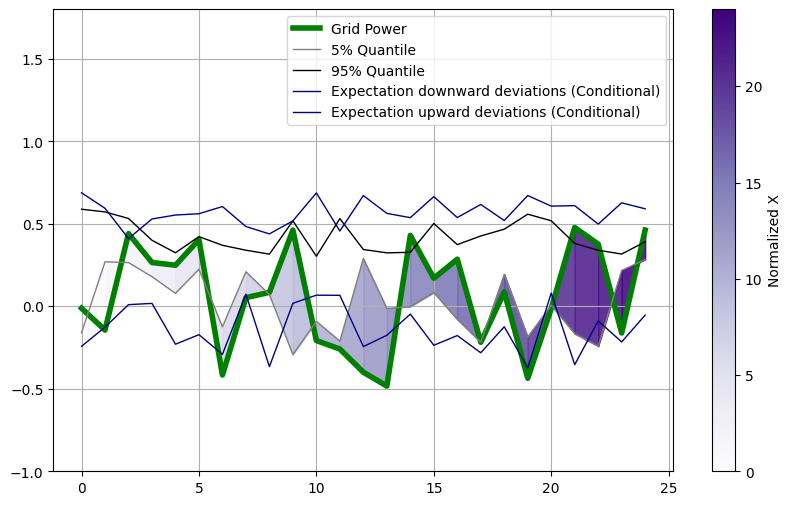

In [294]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Example data
fig, ax = plt.subplots(figsize=(10, 6))

# Example plot lines (use your actual data here)
times = np.linspace(0, 24, 25)
pg_vals = np.random.uniform(-0.5, 0.5, size=25)
pg_05_quantile = np.random.uniform(-0.3, 0.3, size=25)
pg_95_quantile = np.random.uniform(0.3, 0.6, size=25)
pg_exp_low_conditional = np.random.uniform(-0.4, 0.2, size=25)
pg_exp_high_conditional = np.random.uniform(0.4, 0.7, size=25)

ax.plot(times, pg_vals, label='Grid Power', color='green', linewidth=4)
ax.plot(times, np.ravel(pg_05_quantile), label=f'5% Quantile', color='grey', linewidth=1)
ax.plot(times, np.ravel(pg_95_quantile), label=f'95% Quantile', color='black', linewidth=1)
ax.plot(times, pg_exp_low_conditional, label='Expectation downward deviations (Conditional)', color='navy', linewidth=1)
ax.plot(times, pg_exp_high_conditional, label='Expectation upward deviations (Conditional)', color='navy', linewidth=1)

# Colormaps and dummy probabilities (replace with actual probabilities)
cmap = plt.get_cmap('Purples')
x = np.linspace(0, 24, 25)
probabilities = (np.cos(x) + 1) / 2  # Dummy probabilities

# Normalize x to range [0, 1] for the colormap
norm = mcolors.Normalize(vmin=np.min(x), vmax=np.max(x))

for i in range(len(times) - 1):
    # Normalize x[i] for the color map to return correct shade
    color_value = cmap(norm(x[i]))
    
    # Fill between using the normalized color
    ax.fill_between(times[i:i+2], np.ravel(pg_vals)[i:i+2], np.ravel(pg_05_quantile)[i:i+2], 
                    color=color_value, alpha=0.9)

# Add colorbar for colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized X')

plt.grid()
plt.legend()
plt.ylim(-1, 1.8)
plt.show()


In [290]:
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [287]:
probabilities

array([1.00000000e+00, 7.70151153e-01, 2.91926582e-01, 5.00375170e-03,
       1.73178190e-01, 6.41831093e-01, 9.80085143e-01, 8.76951127e-01,
       4.27249983e-01, 4.44348691e-02, 8.04642355e-02, 5.02212849e-01,
       9.21926979e-01, 9.53723391e-01, 5.68368609e-01, 1.20156044e-01,
       2.11702598e-02, 3.62418331e-01, 8.30158354e-01, 9.94352309e-01,
       7.04041031e-01, 2.26135370e-01, 1.95868027e-05, 2.33583490e-01,
       7.12089504e-01])

In [261]:
list(op.prob1.get_values().values())

[0.12999119120121735,
 0.12999119618534058,
 0.13016894276634608,
 0.11526645240498679,
 0.12677508729573506,
 0.1299911958510472,
 0.1251318814440786,
 0.12999119390914043,
 0.12999119320962135,
 0.12214209914086972,
 0.12999119297848008,
 0.12999119273626733,
 0.12999119240671841,
 0.1299914294783524,
 0.12999142900547267,
 0.12999179421473547,
 0.12999179378078457,
 0.12999179336282796,
 0.13673917392955034,
 0.1299911907383051,
 0.1302952848602965,
 0.13142029178864922,
 0.12867238033888695,
 0.12751129330241115]

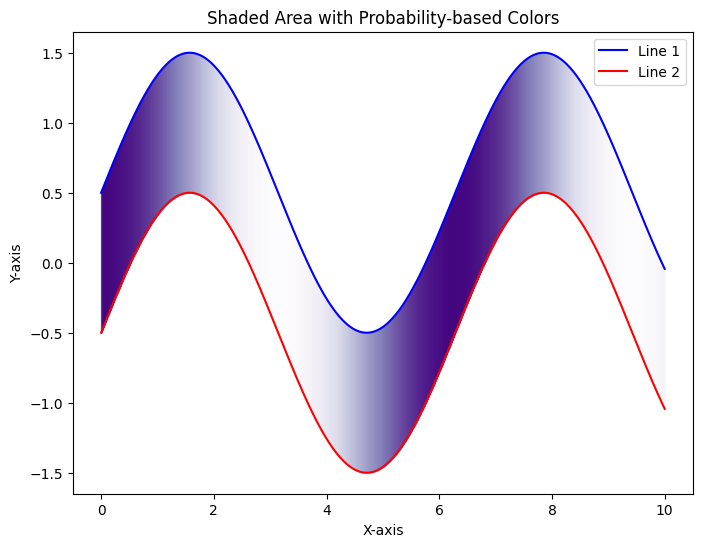

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Example data
x = np.linspace(0, 10, 500)
y1 = np.sin(x) + 0.5
y2 = np.sin(x) - 0.5

# Array of probabilities, normalized between 0 and 1 (for demonstration)
probabilities = (np.cos(x) + 1) / 2  # Just a dummy example of probabilities

# Define a colormap (purple shades)
cmap = plt.get_cmap('Purples')

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the two lines
plt.plot(x, y1, label='Line 1', color='blue')
plt.plot(x, y2, label='Line 2', color='red')

# Fill between the lines with gradient colors
for i in range(len(x) - 1):
    plt.fill_between(x[i:i+2], y1[i:i+2], y2[i:i+2], color=cmap(probabilities[i]), alpha=0.7)

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Shaded Area with Probability-based Colors')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [233]:
op.prob1.display()

prob1 : Size=24, Index=time
    Key                 : Lower : Value               : Upper : Fixed : Stale : Domain
    2020-01-01 12:00:00 :     0 : 0.12999119120121735 :     1 : False : False : NonNegativeReals
    2020-01-01 13:00:00 :     0 : 0.12999119618534058 :     1 : False : False : NonNegativeReals
    2020-01-01 14:00:00 :     0 : 0.13016894276634608 :     1 : False : False : NonNegativeReals
    2020-01-01 15:00:00 :     0 : 0.11526645240498679 :     1 : False : False : NonNegativeReals
    2020-01-01 16:00:00 :     0 : 0.12677508729573506 :     1 : False : False : NonNegativeReals
    2020-01-01 17:00:00 :     0 :  0.1299911958510472 :     1 : False : False : NonNegativeReals
    2020-01-01 18:00:00 :     0 :  0.1251318814440786 :     1 : False : False : NonNegativeReals
    2020-01-01 19:00:00 :     0 : 0.12999119390914043 :     1 : False : False : NonNegativeReals
    2020-01-01 20:00:00 :     0 : 0.12999119320962135 :     1 : False : False : NonNegativeReals
    2020-01-

In [178]:
op.x_high.display()

x_high : Size=24, Index=time
    Key                 : Lower : Value                  : Upper : Fixed : Stale : Domain
    2020-01-01 12:00:00 :     0 :                    0.0 :   5.0 : False : False :  Reals
    2020-01-01 13:00:00 :     0 : 1.8286000404390316e-45 :   5.0 : False : False :  Reals
    2020-01-01 14:00:00 :     0 :                    0.0 :   5.0 : False : False :  Reals
    2020-01-01 15:00:00 :     0 :  2.104018253898575e-45 :   5.0 : False : False :  Reals
    2020-01-01 16:00:00 :     0 :  1.512920061542221e-45 :   5.0 : False : False :  Reals
    2020-01-01 17:00:00 :     0 : 1.3648289239511978e-46 :   5.0 : False : False :  Reals
    2020-01-01 18:00:00 :     0 :  5.187996668171557e-46 :   5.0 : False : False :  Reals
    2020-01-01 19:00:00 :     0 :                    0.0 :   5.0 : False : False :  Reals
    2020-01-01 20:00:00 :     0 :                    0.0 :   5.0 : False : False :  Reals
    2020-01-01 21:00:00 :     0 :                    0.0 :   5.0 : Fals

In [179]:
prosumption_95_quantile

[array([0.57535926]),
 array([0.57535926]),
 array([0.70528045]),
 array([1.16691436]),
 array([0.66087517]),
 array([0.57535926]),
 array([0.65165656]),
 array([0.40608697]),
 array([0.40298241]),
 array([0.75071459]),
 array([0.69835684]),
 array([0.69835684]),
 array([0.69835684]),
 array([0.14969225]),
 array([0.14969225]),
 array([0.12701396]),
 array([0.12701396]),
 array([0.12701396]),
 array([0.31866399]),
 array([0.33026068]),
 array([0.7188147]),
 array([0.68596841]),
 array([1.0805326]),
 array([0.33026068])]

In [161]:
solutions_high

[array([0.57535926]),
 array([0.57535926]),
 array([0.70528045]),
 array([1.16691436]),
 array([0.66087517]),
 array([0.57535926]),
 array([0.65165656]),
 array([0.40608697]),
 array([0.40298241]),
 array([0.75071459]),
 array([0.69835684]),
 array([0.69835684]),
 array([0.69835684]),
 array([0.14969225]),
 array([0.14969225]),
 array([0.12701396]),
 array([0.12701396]),
 array([0.12701396]),
 array([0.31866399]),
 array([0.33026068]),
 array([0.7188147]),
 array([0.68596841]),
 array([1.0805326]),
 array([0.33026068])]

In [197]:
[op.time.at(i+1) for i in range(len(solutions_low))]

[Timestamp('2020-01-01 12:00:00'),
 Timestamp('2020-01-01 13:00:00'),
 Timestamp('2020-01-01 14:00:00'),
 Timestamp('2020-01-01 15:00:00'),
 Timestamp('2020-01-01 16:00:00'),
 Timestamp('2020-01-01 17:00:00'),
 Timestamp('2020-01-01 18:00:00'),
 Timestamp('2020-01-01 19:00:00'),
 Timestamp('2020-01-01 20:00:00'),
 Timestamp('2020-01-01 21:00:00'),
 Timestamp('2020-01-01 22:00:00'),
 Timestamp('2020-01-01 23:00:00'),
 Timestamp('2020-01-02 00:00:00'),
 Timestamp('2020-01-02 01:00:00'),
 Timestamp('2020-01-02 02:00:00'),
 Timestamp('2020-01-02 03:00:00'),
 Timestamp('2020-01-02 04:00:00'),
 Timestamp('2020-01-02 05:00:00'),
 Timestamp('2020-01-02 06:00:00'),
 Timestamp('2020-01-02 07:00:00'),
 Timestamp('2020-01-02 08:00:00'),
 Timestamp('2020-01-02 09:00:00'),
 Timestamp('2020-01-02 10:00:00'),
 Timestamp('2020-01-02 11:00:00')]

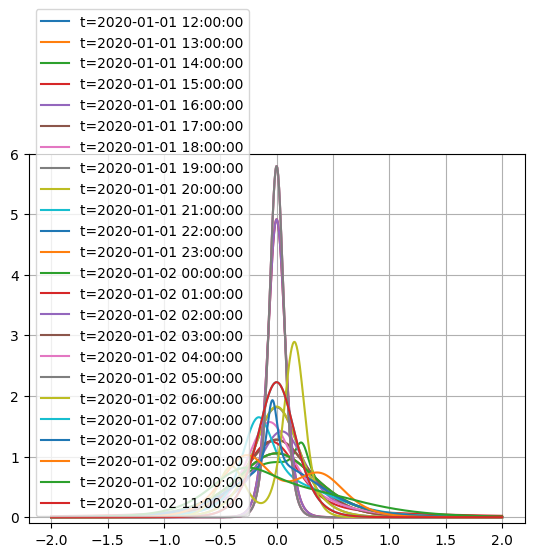

In [201]:
# plot the pdfs
lim = 2
plt.figsize=(20, 12)
for t in op.time:
    x = np.linspace(-lim, lim, 1000)
    y = [sum_2_logistic_pdf(xx, *op.different_weights[t]) for xx in x]
    plt.plot(x, y, label=f't={t}')
    if t == op.time.at(24):
        break
plt.ylim(-0.1, 6)
plt.grid()
plt.legend()

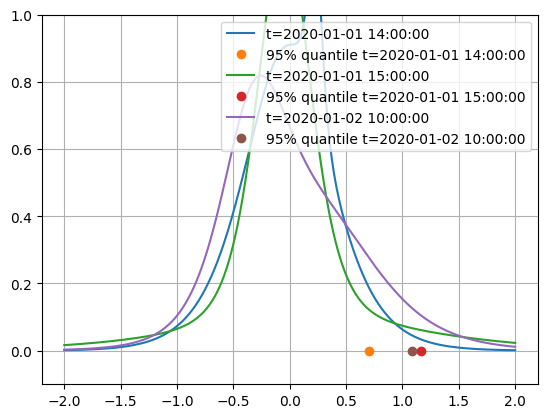

In [211]:
# plot the pdfs
lim = 2
plt.figsize=(20, 12)
for t in op.time:
    which_pdfs = [3, 23, 4]
    for pdf_id in which_pdfs:
        if t == op.time.at(pdf_id):
            x = np.linspace(-lim, lim, 1000)
            y = [sum_2_logistic_pdf(xx, *op.different_weights[t]) for xx in x]
            plt.plot(x, y, label=f't={t}')
            plt.plot(solutions_high[pdf_id-1], 0.0, 'o', label=f'95% quantile t={t}')
    # if t == op.time.at(3) or t == op.time.at(23) or t == op.time.at(4):
    #     x = np.linspace(-lim, lim, 1000)
    #     y = [sum_2_logistic_pdf(xx, *op.different_weights[t]) for xx in x]
    #     plt.plot(x, y, label=f't={t}')
    #     if t == op.time.at(3):
    #         plt.plot(solutions_high[3], 0.05, 'ro')
plt.ylim(-0.1, 1)
plt.grid()
plt.legend()

In [195]:
op.time.display()

time : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   24 : {Timestamp('2020-01-01 12:00:00'), Timestamp('2020-01-01 13:00:00'), Timestamp('2020-01-01 14:00:00'), Timestamp('2020-01-01 15:00:00'), Timestamp('2020-01-01 16:00:00'), Timestamp('2020-01-01 17:00:00'), Timestamp('2020-01-01 18:00:00'), Timestamp('2020-01-01 19:00:00'), Timestamp('2020-01-01 20:00:00'), Timestamp('2020-01-01 21:00:00'), Timestamp('2020-01-01 22:00:00'), Timestamp('2020-01-01 23:00:00'), Timestamp('2020-01-02 00:00:00'), Timestamp('2020-01-02 01:00:00'), Timestamp('2020-01-02 02:00:00'), Timestamp('2020-01-02 03:00:00'), Timestamp('2020-01-02 04:00:00'), Timestamp('2020-01-02 05:00:00'), Timestamp('2020-01-02 06:00:00'), Timestamp('2020-01-02 07:00:00'), Timestamp('2020-01-02 08:00:00'), Timestamp('2020-01-02 09:00:00'), Timestamp('2020-01-02 10:00:00'), Timestamp('2020-01-02 11:00:00')}


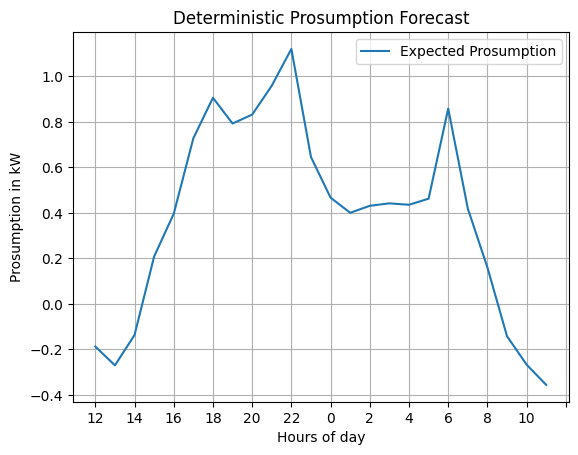

In [23]:
#fig = plt.figure(figsize=(15, 9))
plt.plot(index_values_p, prosumption_logistic_realistic, label='Expected Prosumption')
plt.xlabel('Hours of day')
plt.ylabel('Prosumption in kW')
plt.legend()
plt.xticks(np.arange(0,25,2))
plt.title('Deterministic Prosumption Forecast')
plt.grid()
plt.show()

In [24]:
sum_low = sum([op.x_low[x].value for x in op.x_low])
sum_high = sum([op.x_high[x].value for x in op.x_high])
print(f'Sum of x_low: {sum_low}', f'  Sum of x_high: {sum_high}')

Sum of x_low: -8.165813163317942   Sum of x_high: 2.135692829934309


## Checking correctness of prob1 and prob2
Prob1 and Prob2 should always be chosen accordingly to the specified cdf. When pyomo's piecewise function is used, the specified equalities for the probs do not hold. Here, it is checked if the selected probabilities comply with the specified cdf (normal distribution).
Here, it is only checked for the normal distribution

In [25]:
# print("Computed differences between selected probabilities p1 and p2 and the values originating from the cdf function:")
# print("\n Prob1:")
# for i, xi in enumerate(op.x_low):
#     x = op.x_low[xi].value
#     prob = op.prob1[xi].value
#     p_cdf = cdf_approximations(x, mu=0, sig=different_variances[i], n=100)
#     print(prob - p_cdf)

# print("\n Prob2:")
# for i, xi in enumerate(op.x_high):
#     x = op.x_high[xi].value
#     prob = op.prob2[xi].value
#     p_cdf = 1 - cdf_approximations(x, mu=0, sig=different_variances[i], n=100)
#     print(prob - p_cdf)

## Checking Correctness of Equation pb_tilde = -pg_tilde
In the proposed model, a random variable is divided into two parts. The parts are supposed to have the same absolute expected value, i.e., pb_tilde = - pg_tilde = - E[delta PG_low] - E[delta PG_high].

In [26]:
# todo: For variances = 0.1 => It seems like the difference between pb_tilde and pg_tilde is relatively big (0.001855).
# todo: Check why this is the case! Is the error major or is it neglectable? Maybe increase the number of points in the simpsons rule

In [27]:
pb_tilde = [op.pb_tilde[t].value for t in op.time]
pg_low = [op.exp_delta_pg_low[t].value for t in op.time]
pg_high = [op.exp_delta_pg_high[t].value for t in op.time]
pg_tilde = [pg_low[i] + pg_high[i] for i in range(len(pg_low))]

print('Sum of both expected values:')
for i in range(len(pb_tilde)):
    print(pb_tilde[i] + pg_tilde[i])

Sum of both expected values:
2.54458484422182e-08
2.544584862262944e-08
-4.939698766692757e-08
-0.0007304764788043788
-4.2890969787628963e-07
2.5445849149985378e-08
7.467954310502734e-10
7.222613848667514e-08
7.429182989626693e-08
-2.317839445376002e-08
1.2273507113413906e-08
1.2273507224436209e-08
1.2273507224436209e-08
1.507425074612212e-06
1.5074250765724495e-06
2.507573691034465e-06
2.5075736934700166e-06
2.5075736954198458e-06
3.456037977710158e-07
1.3588072624026726e-07
-1.4619699681417408e-07
2.4779331711521912e-09
-1.789830414614113e-06
1.1478192068689608e-09


In [28]:
normal_pdf_test = lambda x, mu, sig: 1/((2*pi)**0.5 * sig) * pyo.exp(-0.5 * ((x-mu)/sig)**2) 


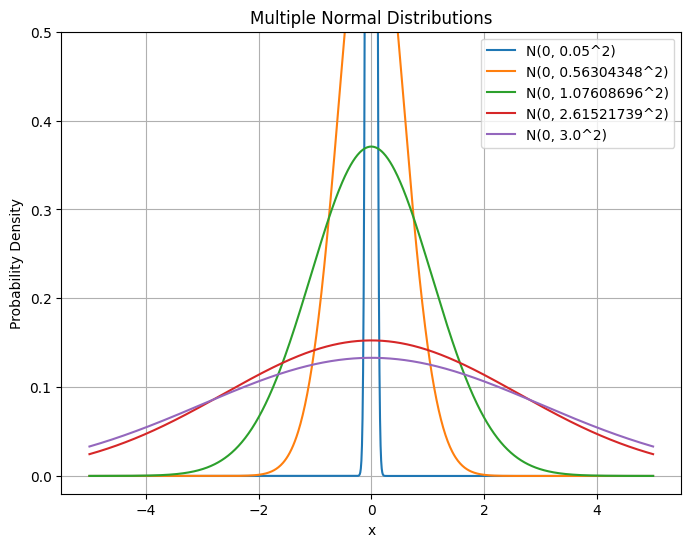

In [29]:
from scipy.stats import norm
mean_list = [0, 0, 0, 0, 0]
std_dev_list = [0.05, 0.56304348, 1.07608696, 2.61521739, 3.0]
x = np.linspace(-5, 5, 1000)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot each normal distribution
for mean, std_dev in zip(mean_list, std_dev_list):
    y =norm.pdf(x, mean, std_dev)
    plt.plot(x, y, label=f'N({mean}, {std_dev}^2)')

# Adding labels, title, and legend
plt.title('Multiple Normal Distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.ylim(-0.02, 0.5)

# Show the plot
plt.show()

In [30]:
# print pb tilde
for i in range(len(pb_tilde)):
    print(pb_tilde[i])

-0.07809139089296879
-0.07809139170985079
-0.08851943004075524
-0.10787842012616833
-0.06141957811050425
-0.07809139446207385
-0.08597936292442981
-0.05511666005595885
-0.054695289047891144
-0.12003931597286921
-0.09478541828396268
-0.09478541855190575
-0.0947854188118702
-0.020316329244105324
-0.020316329300870208
-0.017237697669399515
-0.017237697707252517
-0.017237697739011692
-0.02608881123127319
-0.04482500126644696
-0.09528448237504625
-0.06139760823788535
-0.08762333159621556
0.00756459374729386


In [31]:
for j in range(len(pg_low)): # why is this not always negative?
    print(pg_low[j])

-0.02533335044308913
-0.025333351826287247
-0.033184005539582576
-0.06493261532797658
-0.04549935052908214
-0.025333351547225647
-0.02528934668125778
-0.01788019558578301
-0.017743499873996624
-0.024098706825439735
-0.030748997184426884
-0.03074899708367983
-0.030748996951762135
-0.006590675013514679
-0.006590674974165249
-0.0055919116566149445
-0.005591911626306039
-0.005591911597284307
-0.01445651824954364
-0.014541510613357969
-0.03350585112849907
-0.020342759213379292
-0.032104508238541725
-0.014541509770514481


In [32]:
for j in range(len(pg_high)):
    print(pg_high[j])

0.10342476678190636
0.10342476898198666
0.12170338618335015
0.17208055897534053
0.10691849972988851
0.10342477145514864
0.11126871035248302
0.07299692786788034
0.07243886321371766
0.1441379996199145
0.1255344277418967
0.1255344279090928
0.12553442803713957
0.026908511682694616
0.02690851170011203
0.022832116899705494
0.022832116907252026
0.02283211690999142
0.0405456750846146
0.05936664776053117
0.1287901873065485
0.08174036992919781
0.11972605000434268
0.006976917171039828


In [33]:
pg_low_test = [op.exp_delta_pg_low[t].value * op.prob1[t].value for t in op.time]
pg_high_test = [op.exp_delta_pg_high[t].value * op.prob2[t].value for t in op.time]
pg_tilde_test = [pg_low[i] + pg_high[i] for i in range(len(pg_low))]

In [34]:
pg_high_test

[0.042504769435418754,
 0.042504771025493535,
 0.05195966638942518,
 0.0594863879611883,
 0.0416257734663681,
 0.042504772812934,
 0.04267345930830898,
 0.02999974628535361,
 0.029770396600048925,
 0.05608028794431064,
 0.05159124524191145,
 0.05159124536274989,
 0.05159124545529379,
 0.011058416672853904,
 0.011058416685441844,
 0.009382956230126385,
 0.009382956235580307,
 0.009382956237560077,
 0.017394629391089475,
 0.024398060343971375,
 0.049806415703697295,
 0.025771803845969193,
 0.03125050007375755,
 0.00042076319730151795]

0.00023656176647627518

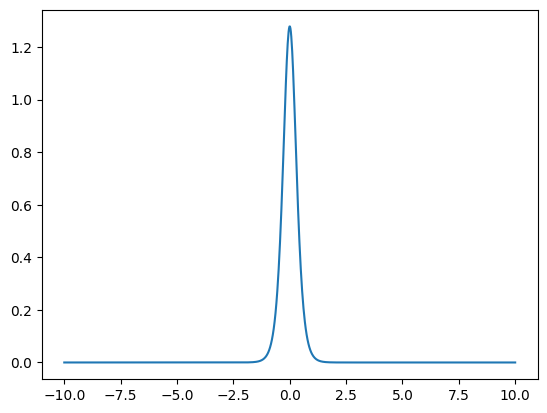

In [35]:
w_all = [0.99967495, 5.117566, 0.00023663824303354897, 0.0, 0.0, -0.7277690317569665]
x = np.linspace(-10, 10, 1000)
y = []
for xi in x:
    y.append(sum_2_logistic_pdf(xi, *w_all))    
plt.plot(x, y)

simpsons_rule_2_logistic(-10, 10, 200, *w_all, offset=0)

0.7277690334239728

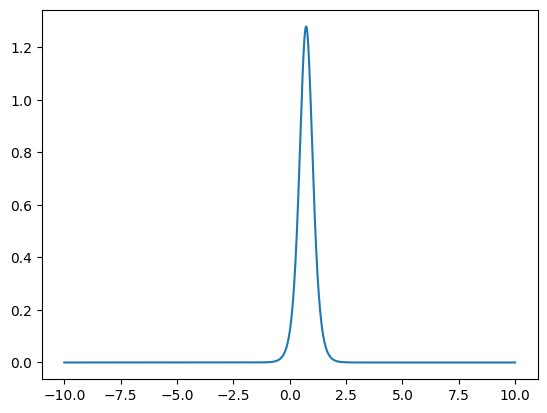

In [36]:
# unshifted
w_all = [0.99967495, 5.117566, 0.72800567, 0.0, 0.0, 0.0]
x = np.linspace(-10, 10, 1000)
y = []
for xi in x:
    y.append(sum_2_logistic_pdf(xi, *w_all))    
plt.plot(x, y)

simpsons_rule_2_logistic(-10, 10, 200, *w_all, offset=0)

4.5761153288518847e-17

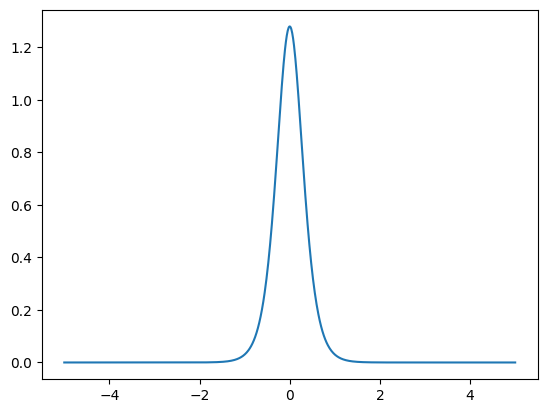

In [37]:
# unshifted
w_all = [0.99967495, 5.117566, 0
, 0.0, 0.0, 0.0
]
x = np.linspace(-5, 5, 1000)
y = []
for xi in x:
    y.append(sum_2_logistic_pdf(xi, *w_all))    
plt.plot(x, y)

simpsons_rule_2_logistic(-5, 5, 200, *w_all, offset=0)

In [38]:
import numpy as np
x = np.linspace(-10,10,10000)
for xi in x:
    print(xi)

-10.0
-9.997999799979999
-9.995999599959996
-9.993999399939995
-9.991999199919992
-9.98999899989999
-9.987998799879987
-9.985998599859986
-9.983998399839985
-9.981998199819982
-9.97999799979998
-9.977997799779978
-9.975997599759976
-9.973997399739973
-9.971997199719972
-9.969996999699969
-9.967996799679968
-9.965996599659967
-9.963996399639964
-9.961996199619962
-9.95999599959996
-9.957995799579958
-9.955995599559955
-9.953995399539954
-9.951995199519953
-9.94999499949995
-9.947994799479948
-9.945994599459945
-9.943994399439944
-9.941994199419941
-9.93999399939994
-9.937993799379939
-9.935993599359936
-9.933993399339935
-9.931993199319932
-9.92999299929993
-9.927992799279927
-9.925992599259926
-9.923992399239925
-9.921992199219922
-9.91999199919992
-9.917991799179918
-9.915991599159916
-9.913991399139913
-9.911991199119912
-9.90999099909991
-9.907990799079908
-9.905990599059907
-9.903990399039904
-9.901990199019902
-9.8999899989999
-9.897989798979898
-9.895989598959895
-9.8939893989398